## Chapter 7 - local mode end-to-end forecasting pipeline
This notebook contains the full code to go along with the the references shown within Chapter 7, section 7.1.3.<br>
Where code listings from the book are defined, they will be annotated to provide reference markers to the text in the book.
> Hyperopt is required to be installed to your environment in order for this notebook to function. Ensure that it is installed by executing the next cell. If it is the first time installing hyperopt into your runtime, reboot your kernel to ensure that all packages are available to the Python REPL.

In [1]:
%pip install hyperopt==0.2.5

Note: you may need to restart the kernel to use updated packages.


To start with, let's place all of the import statements at the top our code to make it easier to keep track of everything that is a dependency for this code to execute.

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import math
from math import sqrt
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from matplotlib import gridspec as gs
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import explained_variance_score, mean_absolute_error, median_absolute_error, mean_squared_error, r2_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
from functools import partial
from contextlib import contextmanager, redirect_stdout, redirect_stderr
from os import devnull
from tqdm.auto import tqdm
import copy

Before we get into any of the 'fun ML stuff' in this notebook, we're going to create a contextmanager override for the hyperopt fmin method. This simple little function below will allow us to take everything that is generated to write out to stdout and stderr and drop it into a black hole of nothingness. Although hyperopt has a verbosity flag that is <i>supposed to</i> prevent this print out of the state of each test that it is iterating through, there are issues with how that is implemented. Therefore, we're going to handle that by providing a means to keep our notebook a bit clean and implement our own verbosity printing flag. <br>
At one point in this notebook we will be showing the verbosity mode turned on (so that you can see what hyperopt is actually doing throughout its run), but to keep you from having to scroll down through dozens of pages of text to see the visualizations, we will be running once with the flag set to False and implementing our own progress tracker.

In [3]:
@contextmanager
def suppress_annoying_prints():
    """ A contextmanager decorated function that allows for 'muting' stdout and stderr while wrapped around 
            another function execution. Specifically used for allowing for hiding the verbosity of hyperopt's
            minimization function.
    """
    with open(devnull, 'w') as black_hole:
        with redirect_stdout(black_hole) as chatter, redirect_stderr(black_hole) as noisy_errors:
            yield (chatter, noisy_errors)

Next, let's define our 'static' definitions (note: nothing is really static in Python. By its very design, everything is mutable, but we can pretend that these are immutable and define them in one place) towards the top as well. This will help us to have a single place to update values that would otherwise be challenging to synchronize throughout the code.
> NOTE: A Production implementation of this would be done through either class-scoped variables or @property annotated methods defined in a reference class.

In [4]:
DATA_PATH = '/opt/notebooks/TCPD/datasets/jfk_passengers/air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv'
AIRPORT_FIELD = 'Airport Code'
SERIES_FREQ = 'MS'
TID_COL = 'TestID'
BIG_FONT = 22
MED_FONT = 16
SMALL_FONT = 14

Now we can define some of our 'utility functions'. For the purposes of keeping this notebook structured similarly to how different modules would be defined in a final code base, we're going to logically group module code together in different cells.<br>
The first module's worth of code will be for data acquisition, formatting, splitting, and validation.

In [5]:
def apply_index_freq(data, freq):
    """ Function for applying the correct temporal frequency to the Index of the Pandas DataFrame
    :param data: a Pandas DataFrame that has a date or datetime index set
    :param freq: a timespan frequency string. See 
        https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
        for more information on allowable frequency strings.
    """
    return data.asfreq(freq)

def pull_raw_airport_data(file_location):
    """ Function for reading in the raw .csv file containing the airport timeseries data
    :param file_location: the location on disk that the .csv is stored.
    """
    raw = pd.read_csv(file_location)
    raw = raw.copy(deep=False)
    raw['Month'] = pd.to_datetime(raw['Month'], format='%b').dt.month
    raw.loc[:, 'Day'] = 1
    raw['date'] = pd.to_datetime(raw[['Year', 'Month', 'Day']])
    raw.set_index('date', inplace=True)
    raw.index = pd.DatetimeIndex(raw.index.values, freq=raw.index.inferred_freq)
    asc = raw.sort_index()
    return asc


def get_airport_data_from_df(full_file, freq, airport):
    """ Function for filtering out a single airport from the full file
    :param full_file: the read-in DataFrame of the airport .csv
    :param freq: the timespan frequency string for the index temporal component
    :param airport: the airport key code to filter upon
    """
    filtered = full_file[full_file[AIRPORT_FIELD] == airport]
    return apply_index_freq(filtered, freq)

def get_airport_data(file_location, freq, airport):
    """ Function for acquiring the raw file and filtering to a single airport (mostly for testing)
    :param file_location: the location on disk of the airport .csv file
    :param freq: the timespan frequency string for the index temporal component
    :param airport: the airport key code to filter upon
    """
    all_data = pull_raw_airport_data(file_location)
    # note the use of a partial function here. While not expressly required for this particular use case,
    # I have included this functional programming paradigm here to introduce the concept of currying
    # within ML code (something that is a rare sight to see in most code bases).
    # When there is more complex chaining of functional chains of operations, using partial functions can
    # make your code base MUCH cleaner (translation: less typing) and easier to maintain.
    return partial(get_airport_data_from_df, all_data, freq)(airport)

def get_all_airports_from_df(full_file):
    """ Function for returning the unique list of airports contained within the data set.
    :param full_file: 
    """
    return sorted(full_file[AIRPORT_FIELD].unique())

def generate_splits_by_months(data, months):
    """ Function for creating the train and test splits for the models, filling in missing index sequences 
            with a forward fill first (conservative estimation), followed by a backfill if the beginning of the
            series starts with a (or many) NaN value(s).
    :param data: a Pandas DataFrame object with a monthly date index
    :param months: the number of months to utilize for validation through the test set row count.
    """
    train = data[:-months].fillna(method='ffill').fillna(method='bfill')
    test = data[-months:].fillna(method='ffill').fillna(method='bfill')
    return train, test

def validate_data_counts(data, split_count):
    """ A utility validation function that checks to make sure that we have enough data to train on.
            The return type of this is a boolean that is used to determine whether we should attempt to 
            model this airport or not (if we can't, we can fallback to a simpler methodology that, although
            likely less accurate, can be a placeholder until we have enough data to trust in the predictions
            that a statistical model will give).
    :param data: the full data set prior to splitting into test and train
    :param split_count: the cutoff count for test data to ensure that we have enough of a ratio for the 
        model's training to hit at least a ratio of 80% train to 20% test. 
    """
    return split_count / 0.2 < len(data) * 0.8

Now that we have the data acquisition and manipulation functions defined 
>keep in mind that these would later be ported over to two separate classes performing these functions in production code:
* one class for data ingestion, filtering, and application of the index
* one class for data splitting and validation of the splits
<br>
<p>For the next phase of defined functions, we're going to want to expand the loss calculations that we worked on in the prototype for Chapter 6. Upon further research, we discovered that we might want to also capture (and perhaps optimize upon) either Akaike's Information Criterion (aic) and Bayesian Information Criterion (bic), two loss metrics that are specifically designed to evaluate the quality of hyperparameter optimization for a particular model. </p>
<br>
<h>
You can read more about aic and bic here: </h>
<p>
aic -> http://www.sortie-nd.org/lme/Statistical%20Papers/Akaike_1973%20with%20commentary.pdf (this one is nice since it is a commentary on Akaike's original 1973 paper)<br>
bic -> https://projecteuclid.org/euclid.aos/1176344136 (Schwarz's original paper in 1978)<br><br>
Let's get all of the loss metrics defined in one spot so we can call them as needed in the rest of the code.</p>

In [6]:
def mape(y_true, y_pred):
    """ Function for calculating Mean Absolute Percentage Error (MAPE) for comparing different models 
    :param y_true: The test holdout validation data (actual data during the test period)
    :param t_pred: The forecast prediction over the same temporal period as the test holdout series.
    """
    drop_case = y_true != 0
    return (np.fabs(y_true - y_pred) / y_true)[drop_case].mean() * 100

def aic(n, mse, param_count):
    """ Function for Akaike's Information Criterion (aic)
    :param n: the length of the series that is under test (in terms of a Pandas DataFrame, it's your row 
            count of test)
    :param mse: the mean squared error calculation for the test vs. predicted data
    :param param_count: the number of hyperparameters under test for the algorithm being evaluated.
    """
    return n * np.log(mse) + 2 * param_count

def bic(n, mse, param_count):
    """ Function for Schwarz's Bayesian Information Criterion (bic)
    :param n: the length of the series that is under test (in terms of a Pandas DataFrame, it's your row 
            count of test)
    :param mse: the mean squared error calculation for the test vs. predicted data
    :param param_count: the number of hyperparameters under test for the algorithm being evaluated.
    """
    return n * np.log(mse) + param_count * np.log(n)

def calculate_errors(y_true, y_pred, param_count):
    """ Function for calculation of the errors that we want to record for each of the iterations of hyperparameter
            testing. 
            NOTE: the try/catch blocks in here are for handling the nigh inevitable loss errors that will 
            occur when trying certain combinations of parameters that will cause the predicted series to 
            either rise to positive infinity or drop to negative infinity. By having the placeholders set
            with a very large error value, we can disincentivize hyperopt from continuing to search in the space
            that generates such poor values, while not throwing a math error that would abort the run.
        :param y_true: the test holdout validation data
        :param y_pred: the forecast data
        :param param_count: required data for both aic and bic loss metrics
    """
    error_scores = {}
    pred_length = len(y_pred)
    try: 
        mse = mean_squared_error(y_true, y_pred)
    except ValueError:
        mse = 1e12
    try:
        error_scores['mae'] = mean_absolute_error(y_true, y_pred)
    except ValueError:
        error_scores['mae'] = 1e12
    try:
        error_scores['medae'] = median_absolute_error(y_true, y_pred)
    except ValueError:
        error_scores['medae'] = 1e12
    error_scores['mape'] = mape(y_true, y_pred)
    error_scores['mse'] = mse
    error_scores['rmse'] = sqrt(mse)
    error_scores['aic'] = aic(pred_length, mse, param_count)
    error_scores['bic'] = bic(pred_length, mse, param_count)
    try:
        error_scores['explained_var'] = explained_variance_score(y_true, y_pred)
    except ValueError:
        error_scores['explained_var'] = -1e4
    try:
        error_scores['r2'] = r2_score(y_true, y_pred)
    except ValueError:
        error_scores['r2'] = -1e4
        
    return error_scores

NOTE: As I mentioned in the text for Chapter 7, I'm a fan of bic more so than aic. This is due to the fact that bic penalizes evaluations that have numbers of hyperparameters, thus making it more challenging to arrive at an optimal set of hyperparameters. This is relatively important when using a tool like hyperopt or a genetic algorithm due to <i><b> how they select subsequent iterations of search space based on priors</b></i>. Basically, the more challenging it becomes to get a 'good result', the more these algorithms will have to search, aiding their ability to converge to very close to a global minima. 

In this next block, we are going to look at the plotting functions and group them together (as we mentioned before, in production code bases, similar functionality is typically grouped together in a repository at the module level to aid humans in finding where particular parts of the code base are defined). <br>
This is an important call-out, to be honest. To the computer, the kernel, the vm, and (if applicable) the compiler, where you place particular functionality matters not. It will resolve the paths and references just fine on its own, regardless of how messy and chaotic that you make it. The only one to benefit from clean and logically arranged code is you, dear developer, and your fellow humans. Do yourself and your other humans a favor and place similar things in a logical arrangement that makes it easy for others to find where things are implemented.<br><br>
And now on to the visualizations...<br>
Well, before we do those, we need a few 'helper functions' to extract information from the hyperopt Trials() object (the tracker of everything that hyperopt is doing during its bayesian optimization phases). Let's define those first (since they're required to plot the hyperopt trials visualizations) and then we'll move on to the pretty plots.

In [7]:
def extract_param_count_hwes(config):
    """ A function to extract the number of configured hyperparameters submitted (for aic and bic calculation)
    :param config: an instance of the hyperopt space configuration for the optimization function
    """
    return len(config['model'].keys()) + len(config['fit'].keys())

def extract_individual_trial_params(hpopt_config, run):
    """ Function for extracting the parameters that were under test for a specific iteration of hyperopt's 
            optimization.
    :param hpopt_config: the space configuration that is submitted to hyperopt
    :param run: an individual run (trial model) of hyperopt iteration from the Trials() object
    """
    return space_eval(hpopt_config, {k:v[0] for (k, v) in run['misc']['vals'].items() if v})

def extract_metric(run, metric_name):
    """ Function for extracting the metric (loss) values from a particular trial of hyperopt
    :param run: A trial (model) from Trials() 
    :param metric_name: The name of the loss metric column to store each of the metrics used within
    """
    test_ids = [x['tid'] + 1 for x in run]
    test_metric = [x['result']['loss'] for x in run]
    return pd.DataFrame(list(zip(test_ids, test_metric)), columns=[TID_COL, metric_name])

def collapse_dict(trial_params):
    """ Function for un-nesting the structure of the trial to get all of the keys and values at the same level
    :param trial_params: the parameters set for the particular run to resolve the names of the settings
        for categorical / boolean hyperparameters from their indexed encodings back to the original values.
    """
    values = {}
    for (k, v) in trial_params.items():
        if isinstance(v, dict):
            values = {**values, **collapse_dict(v)}
        else:
            values[k] = v
    return values

def extract_hyperopt_trials(trials_run, trials_configuration, metric_name):
    """ Function (main access point for this cell / module) for extracting the run history of a hyperopt 
            minimization function run
    :param trials_run: the historical Trials() run Object
    :param trials_configuration: the submitted configuration search space to hyperopt (for resolving names 
            and attributes)
    :param metric_name: The optimization metric name that hyperopt is using to optimize for
    """
    extracted_params = [collapse_dict(extract_individual_trial_params(trials_configuration, x)
                                     ) for x in trials_run.trials]
    params_df = pd.DataFrame(extracted_params)
    params_df[TID_COL] = [x['tid'] + 1 for x in trials_run]
    return extract_metric(trials_run, metric_name).merge(params_df, on=TID_COL)

Ok, now we have everything that we need to do the visualizations.<br>
Here they are.

In [8]:
def plot_predictions(y_true, y_pred, param_count, time_series_name, value_name, 
                     image_name, style='seaborn', plot_size=(16, 12)):
    """ Function for plotting of the validation data (test) vs. the forecast within the test temporal period.
    :param y_true: the actual test series data (ground truth)
    :param y_pred: our forecast during the period of the test data
    :param param_count: the number of hyperparameters that are being tested (for aic/bic calculations)
    :param time_series_name: A name for the series to place as labels for the plot
    :param value_name: Name for labelling the series of data that is being plotted.
    :param image_name: Name for the image to be saved to disk as in .svg format.
    :param style: (default: seaborn) for visual style of the generated plot.
    :param plot_size: (default: (16, 12)) size of the generated plot in inches.
    """
    validation_output = {}
    error_values = calculate_errors(y_true, y_pred, param_count)
    validation_output['errors'] = error_values
    text_str = '\n'.join((
        'mae = {:.3f}'.format(error_values['mae']),
        'medae = {:.3f}'.format(error_values['medae']),
        'mape = {:.3f}'.format(error_values['mape']),
        'aic = {:.3f}'.format(error_values['aic']),
        'bic = {:.3f}'.format(error_values['bic']),
        'mse = {:.3f}'.format(error_values['mse']),
        'rmse = {:.3f}'.format(error_values['rmse']),
        'explained var = {:.3f}'.format(error_values['explained_var']),
        'r squared = {:.3f}'.format(error_values['r2']),
    ))
    with plt.style.context(style=style):
        fig, axes = plt.subplots(1, 1, figsize=plot_size)
        axes.plot(y_true, 'b-', label='Test data for {}'.format(time_series_name))
        axes.plot(y_pred, 'r-', label='Forecast data for {}'.format(time_series_name))
        axes.legend(loc='upper left', fontsize=MED_FONT)
        axes.set_title('Raw and Predicted data trend for {}'.format(time_series_name))
        axes.set_ylabel(value_name)
        axes.set_xlabel(y_true.index.name)
        for i in (axes.get_xticklabels() + axes.get_yticklabels()):
            i.set_fontsize(SMALL_FONT)  
        for i in [axes.title, axes.xaxis.label, axes.yaxis.label]:
            i.set_fontsize(BIG_FONT)
        props = dict(boxstyle='round', facecolor='oldlace', alpha=0.5)
        axes.text(0.05, 0.9, text_str, transform=axes.transAxes, fontsize=MED_FONT, 
                  verticalalignment='top', bbox=props)
        validation_output['plot'] = fig
        plt.savefig(image_name, format='svg')
        plt.tight_layout()
    return validation_output


def annotate_num(x, y, z, metric, param, ax):
    """ Function for generating the annotation box for the hyperopt report for numeric type hyperparameters
    :param x: series for the x axis plotting
    :param y: series for the y axis plotting
    :param z: series for the color-value plotting
    :param metric: name of the metric that is being optimized
    :param ax: the axis that the annotation will be attached to (which plot to superimpose it over)
    """
    xmax = x[np.argmin(y)]
    ymax = y.min()
    zmax = z[np.argmin(y)]
    text_value = "Best Model\n{}={:.4f} \niteration={} \n{}={:.3f}".format(param, xmax, zmax, metric, ymax)
    bbox_config = dict(boxstyle='round,pad=0.5', fc='ivory', ec='grey', lw=0.8)
    arrow = dict(facecolor='darkblue', shrink=0.01, connectionstyle='angle3,angleA=90,angleB=45')
    conf = dict(xycoords='data',textcoords='axes fraction',arrowprops=arrow,
                bbox=bbox_config,ha='left', va='center', fontsize=MED_FONT)
    ax.annotate(text_value, xy=(xmax,ymax), xytext=(0.3,0.8), **conf)
    
def annotate_str(x, y, data, metric, param, ax):
    """ Function for generating the annotation box for the hyperopt report for categorical (string) type 
            hyperparameters
    :param x: series for the x axis plotting (the points are jittered)
    :param y: series for the y axis plotting
    :param data: the full DataFrame used in plotting (for acquiring the categorical values and their names)
    :param metric: name of the metric being optimized by hyperopt
    :param ax: the axis of the figure that the annotation will be attached to (which plot to superimpose it over)
    """
    xmax = x[np.argmin(y)]
    ymax = y.min()
    text_value = "Best Model\n{}={} \niteration={} \n{}={:.3f}".format(
        param, data[param].values[0], data[TID_COL].values[0], metric, ymax)
    bbox_config = dict(boxstyle='round,pad=0.5', fc='ivory', ec='grey', lw=0.8)
    arrow = dict(facecolor='darkblue', shrink=0.01, connectionstyle='angle3,angleA=90,angleB=45')
    conf = dict(xycoords='data',textcoords='axes fraction',arrowprops=arrow,
                bbox=bbox_config,ha='left', va='center', fontsize=MED_FONT)
    ax.annotate(text_value, xy=(xmax,ymax), xytext=(0.3,0.8), **conf)

def generate_hyperopt_report(hpopt_df, metric, plot_name, image_name, fig_size=(16, 36)):
    """ Function for building the hyperopt tuning and optimization plots 
    :param hpopt_df: The DataFrame that is extracted from the Trials() object through the use of 
        extract_hyperopt_trials() function
    :param metric: The metric that hyperopt used to optimize against
    :param plot_name: The name of the figure holding the collections of plots
    :param image_name: The name of the image file to save to disk as .svg
    :param fig_size: (default (16,36)) the size of the figure in inches.
    """
    params = [x for x in list(hpopt_df) if x not in [TID_COL, metric]]
    COLS = 2
    ROWS = int(math.ceil(len(params)/COLS))
    with plt.style.context(style='seaborn'):
        u_filter = hpopt_df[metric].quantile(0.9)
        grid = gs.GridSpec(ROWS, COLS)
        fig = plt.figure(figsize=fig_size)
        for i in range(len(params)):
            column = params[i]
            unique_vals = sorted(hpopt_df[column].unique())
            ax = fig.add_subplot(grid[i])
            if len(unique_vals) > 6:
                x = hpopt_df[column]
                y = hpopt_df[metric]
                im = ax.scatter(x=x, y=y, c=hpopt_df[TID_COL], marker='o', s=80, cmap=plt.cm.coolwarm, alpha=0.6)
                fig.colorbar(im, ax=ax, orientation='vertical')
                annotate_num(x, y, hpopt_df[TID_COL], metric, column, ax)
            else:
                j = 0
                min_metric_row = hpopt_df[hpopt_df[metric] == hpopt_df[metric].min()]
                for i in unique_vals:
                    y_interim = hpopt_df[hpopt_df[column] == i]
                    y_pre_filter = y_interim[(y_interim[metric] < u_filter)]
                    y = y_pre_filter[metric]
                    ax.boxplot(y, positions=[j+1], widths=0.4)
                    if isinstance(i, str): 
                        x = np.random.normal(1+j, 0.05, size=len(y))
                    else:
                        x = np.random.normal(1+i, 0.05, size=len(y))
                    sp = ax.scatter(x=x, y=y, c=y_pre_filter[TID_COL], marker='o', alpha=0.6, s=80, 
                                    cmap=plt.cm.coolwarm)
                    if min_metric_row[metric].values[0] in y_pre_filter[metric].values:
                        annotate_str(x, y, min_metric_row, metric, column, ax)
                    j+=1
                fig.colorbar(sp, ax=ax, orientation='vertical')
                ax.set_xticklabels(unique_vals)
            ax.set_title('Hyperopt trials {} vs. {}'.format(column, metric))
            ax.set_ylabel(metric)
            ax.set_xlabel(column)
            for i in (ax.get_xticklabels() + ax.get_yticklabels()):
                i.set_fontsize(SMALL_FONT)  
            for i in [ax.title, ax.xaxis.label, ax.yaxis.label]:
                i.set_fontsize(MED_FONT)
        fig.suptitle(plot_name, size=BIG_FONT)
        fig.tight_layout()
        fig.subplots_adjust(top=0.96)
        plt.savefig(image_name, format='svg')
    return fig

def generate_forecast_plots(forecast_data, **plot_conf):
    """ Function for generating the forecast plots for a particular airport
    :param forecast_data: the calculated projected forecast with some amount of the historical test region data
        to show the goodness of fit in a single plot.
    :param plot_conf: dictionary of:
                        plot_conf = {
                            'forecast_col': <Name of the column used for forecasted data>,
                            'target_col': <Name of the actual series used for model training>,
                            'image_base_name': <name to append to the airport name to identify it as forecasted data>,
                            'figsize': <A Tuple-2 of (x,y) for the size of the plot in inches>
                        }
    """
    images = []
    for airport in forecast_data['Airport'].unique():
        filtered = forecast_data[forecast_data['Airport'] == airport]
        real_data = filtered[plot_conf['target_col']]
        forecast_historic = filtered[filtered['is_future'] == False][plot_conf['forecast_col']]
        forecast_future = filtered[filtered['is_future'] == True][plot_conf['forecast_col']]
        min_scale = np.min([filtered[plot_conf['forecast_col']].min(), filtered[plot_conf['target_col']].min()])
        forecast_boundary = filtered[filtered['is_future'] != True].index[-1]
        with plt.style.context(style='seaborn'):
            fig, ax = plt.subplots(1,1,figsize=plot_conf['figsize'])
            ser1 = ax.plot(real_data, 'b-', label='Historic Data for {} at {}'.format(
                plot_conf['target_col'], airport))
            ser2 = ax.plot(forecast_historic, 'r--.', label='Forecast during historic for {} at {}'.format(
                plot_conf['target_col'], airport))
            ser3 = ax.plot(forecast_future, 'r:o', label='Future forecast for {} at {}'.format(
                plot_conf['target_col'], airport))
            ax.legend(loc='upper left', fontsize=MED_FONT)
            ax.set_title('Raw, Predicted, and Forecast data for {}'.format(airport))
            ax.set_ylabel(plot_conf['target_col'])
            ax.set_xlabel('Date')
            boundary = ax.axvline(forecast_boundary, color='black')
            bbox_conf = dict(boxstyle='round,pad=0.5', fc='ivory', ec='k', lw=0.8)
            left_box = ax.text(forecast_boundary - relativedelta(months=1), 
                               min_scale, 
                               "<-- Historic Data", 
                               bbox=bbox_conf, 
                               fontsize=MED_FONT,
                               ha='right'                              
                              )
            right_box = ax.text(forecast_boundary + relativedelta(months=1), 
                                min_scale, 
                                "Forecast Data -->", 
                                bbox=bbox_conf, 
                                fontsize=MED_FONT)
            for i in (ax.get_xticklabels() + ax.get_yticklabels()):
                i.set_fontsize(SMALL_FONT)  
            for i in [ax.title, ax.xaxis.label, ax.yaxis.label]:
                i.set_fontsize(BIG_FONT)
            plt.tight_layout()
            plt.savefig('{}{}'.format(airport, plot_conf['image_base_name']), format='svg')
            images.append(fig)
    return images

Now that we have the ability to acquire our data, split it, score predictions, and make some super sweet plots out of our data, we should probably focus on the ML aspect of this.<br>
Let's define the minimization function...

### Listing 7.4 Minimization function for Holt-Winters Exponential Smoothing
Here's the area that we focused on in Chapter 7 for defining how we're going to use hyperopt to evaluate a particular selected search space hyperparameter configuration. The hwes_minimization_function, included below, is part of the control methodology that we'll see in the next portion (the job execution block)

In [9]:
def exp_smoothing_raw(train, test, selected_hp_values):
    """ Function for executing the model 'manually' (outside of hyperopt) without the embedded scoring.
    :param train: the training series data
    :param test: the test (validation) series data
    :param selected_hp_values: the instance of hyperparameter settings that hyperopt will provide upon selecting
        from the search space.
    
    Note: this is split out for two reasons: firstly, it's part of what hyperopt will need to call to build the
        model and run a forecast error metric calculation for tuning. Secondly, it is a useful manual-mode 
        validation of particular parameter selections (useful for debugging).
    """
    output = {}
    model = ExponentialSmoothing(train, 
                               trend=selected_hp_values['model']['trend'],
                               seasonal=selected_hp_values['model']['seasonal'],
                               seasonal_periods=selected_hp_values['model']['seasonal_periods'],
                               damped=selected_hp_values['model']['damped']
                              )
    model_fit = model.fit(smoothing_level=selected_hp_values['fit']['smoothing_level'],
                          smoothing_seasonal=selected_hp_values['fit']['smoothing_seasonal'],
                          damping_slope=selected_hp_values['fit']['damping_slope'],
                          use_brute=selected_hp_values['fit']['use_brute'],
                          use_boxcox=selected_hp_values['fit']['use_boxcox'],
                          use_basinhopping=selected_hp_values['fit']['use_basinhopping'],
                          remove_bias=selected_hp_values['fit']['remove_bias']
                         )
    forecast = model_fit.predict(train.index[-1], test.index[-1])
    output['model'] = model_fit
    output['forecast'] = forecast[1:]
    return output

def hwes_minimization_function(selected_hp_values, train, test, loss_metric, progress):
    """ Function for minimization. Accepts the selected hyperparameter values that hyperopt has chosen and 
            builds the model with those, predicts against test, scores, and returns the loss metric.
    :param selected_hp_values: a dictionary that hyperopt has chosen from the defined space.
    :param train: The training data series
    :param test: The test data series
    :param loss_metric: the loss metric that hyperopt is using for optimization.
    :param progress: reference to the progress tracker to display the progress of optimizing for this run.
    """
    model_results = exp_smoothing_raw(train, test, selected_hp_values)
    errors = calculate_errors(test, model_results['forecast'], extract_param_count_hwes(selected_hp_values))
    progress.update()
    return {'loss': errors[loss_metric], 'status': STATUS_OK}

<b><u>NOTE</u></b> As mentioned in the docstring for exp_smoothing_raw, we split out the core modeling logic from the minimization function that hyperopt will be using. While we're not directly using the exp_smoothing_raw in this MVP, I can assure you that I used it while testing out different search space settings for hyperopt's parameter space. This approach of extracting out otherwise monolithic operations into different functions does a number of things for you as a developer:
1. <b>Legibility.</b> Helps you and others read your code. Think about every time you've seen a code base that has a function or method with 300 lines of code... did you have a feeling of dread when you saw that and realized that in order to figure out what it was doing you would have to walk through 300 lines of code?
2. <b>Maintainability.</b> If you have a bug in a monolithic function or method, <i>how are you going to fix it?</i> How are you going to <i><b>find it?!!</b></i>
3. <b>Extensibility.</b> If you want to add new functionality somewhere in the middle of a massive function... where do you add it? How do you test that functionality and ensure that it's doing what you want it to do? Splitting it up makes this process MUCH easier.
4. <b>Testability.</b> Think of all of the hidden states of operations that could be buried in a monolithic function or method. How are you going to test it all? (Spoiler alert: you can't.) All you can test from a monolithic function or method is the output against a known condition with test data. The more operations that you cram into a single grouping of code, the less insight you will have about WHAT failed WHERE in the code.

Now that we have the two main functions for 'building the models' (one for tuning, one for forecasting), we can move to the 'command and control' portions of making all of this run.<br>
In this next section, we will be defining the primary execution logic for performing a single airport's auto-tuning through hyperopt, as well as a 'meta function' that will loop through each of the airports, check to make sure that there is enough data to perform a forecast, run hyperopt to find the optimal parameters, and return the tuning history of each airport.

### Listing 7.6 Hyperopt Tuning Execution
We'll be defining the run_tuning() function in this code block, as referenced in the text. We'll also be defining the 'meta function' that will loop through all of the airports that was not included in the book for brevity's sake. At the tail-end of this code block are two functions for building the forecast dataset and the actual prediction (inference) series for each airport.

> <b>NOTE: The code example here varies <i>slightly</i> from the code in Chapter 7, intentionally so. For the purposes of showing a more efficient way of handling disk I/O, this implementation uses a DataFrame for the 'full data' that has been loaded <u>once</u>, as opposed to the book's implementation that loads the airport within this loop from disk each iteration.</b><br><br>

For fun, see if you can see the differences and try to reason about why one approach is better than another.

In [10]:
def run_tuning(train, test, **params):
    """ Function for executing the hyperopt auto-tuning for a single airport.
    :param train: the train series data
    :param test: the test (holdout) series data for loss metric calculation
    :param **params: dict, consisting of:
                 {'minimization_function': <the model training, evaluation, and loss estimation function>,
                  'tuning_space': <the hyperopt search space configuration>,
                  'forecast_algo': <the function for forecasting the data>,
                  'loss_metric': <the loss metric (e.g. 'aic', 'bic', 'mse', et al.)>,
                  'hpopt_algo': <the hyperopt optimization [recommended to choose either 
                                  tpe.suggest or random.suggest]>,
                  'iterations': <number of iterations for hyperopt to search through>,
                  'name': <the base name to be applied to visualizations as titles>,
                  'target_name': <The name of the 'target' column in the data (what we are trying to predict)>,
                  'image_name': <the base name of the images to be saved, which will get appended to the 
                                  airport name>,
                  'airport_name': <the name of the airport, for both labeling and filtering purposes>,
                  'future_forecast_periods': <the number of months to forecast in the future>,
                  'train_split_cutoff_months': <the number of months of data from the end of the series to 
                                    use as test data (the diff of this will be training data)>,
                  'hyperopt_title': <name for setting the hyperopt training report title>,
                  'hyperopt_image_name': <name for the saved images of the hyperopt training information which
                                    will get modified with the name of the airport>,
                  'verbose': <Boolean value that will control whether to print a bunch of information to stdout
                              while the optimization is running>,
                  'progress': <a progress monitor instantiation to give live notebook-formatted progress
                              of the optimization process>
                   }
    
    """
    param_count = extract_param_count_hwes(params['tuning_space'])
    output = {}
    trial_run = Trials()
    tuning = fmin(partial(params['minimization_function'], 
                          train=train, 
                          test=test,
                          loss_metric=params['loss_metric'],
                          progress=params['progress']
                         ), 
                  params['tuning_space'], 
                  algo=params['hpopt_algo'], 
                  max_evals=params['iterations'], 
                  trials=trial_run,
                  verbose=params['verbose'],
                  catch_eval_exceptions=True
                 )
    best_run = space_eval(params['tuning_space'], tuning)
    generated_model = params['forecast_algo'](train, test, best_run)
    extracted_trials = extract_hyperopt_trials(trial_run, params['tuning_space'], params['loss_metric'])
    output['best_hp_params'] = best_run
    output['best_model'] = generated_model['model']
    output['hyperopt_trials_data'] = extracted_trials
    output['hyperopt_trials_visualization'] = generate_hyperopt_report(extracted_trials, 
                                                                       params['loss_metric'], 
                                                                       params['hyperopt_title'], 
                                                                       params['hyperopt_image_name'])
    output['forecast_data'] = generated_model['forecast']
    output['series_prediction'] = build_future_forecast(generated_model['model'],
                                                        params['airport_name'],
                                                        params['future_forecast_periods'],
                                                        params['train_split_cutoff_months'],
                                                        params['target_name']
                                                       )
    output['plot_data'] = plot_predictions(test, 
                                           generated_model['forecast'], 
                                           param_count,
                                           params['name'], 
                                           params['target_name'], 
                                           params['image_name'])
    return output


def run_all_models(**config):
    """ Function for running automated hyperopt-tuned forecast models for each airport in the dataset.
    :param **config: Dictionary of structure:
        all_model_config = {
            'source_data': <location of the raw data for the airports>,
            'train_split_cutoff_months': <the number of months of data from the end of the series to 
                                    use as test data (the diff of this will be training data)>,
            'future_forecast_periods': <the number of months to forecast in the future>,
            'series_freq': <string formatted time periodicity configuration for the index of the series>,
            'forecast_field': <name of the field to be applied for forecasting purposes>,
            'base_config': {
                              'minimization_function': <the minimization function for Exponential Smoothing>,
                              'tuning_space': <hyperopt tuning space for ExponentialSmoothing>,
                              'forecast_algo': <the forecast function for the model>,
                              'loss_metric': <the loss metric for optimization>,
                              'hpopt_algo': <hyperopt's optimization algorithm (either tpe or random)>,
                              'iterations': <number of iterations for hyperopt to optimize>,
                              'base_name': <the base name to be applied to labels in visualizations>,
                              'target_name': <the column name of the series to be predicted>,
                              'fit_base_image_name': <the base of the saved image name for the 
                                  forecast visualizations>,
                              'tuning_base_image_name': <the base of the save image name for hyperopt 
                                  visualizations>,
                              'verbose': <Boolean flag for whether to print status to stdout for hyperopt>
                            }
            }
    """
    all_data = pull_raw_airport_data(config['source_data'])
    model_outputs = {}
    airports = get_all_airports_from_df(all_data)
    base = config['base_config']
    for airport in airports:
        data = get_airport_data_from_df(all_data, config['series_freq'], airport)
        if validate_data_counts(data, all_model_config['train_split_cutoff_months']):
            print("Starting tuning of Airport {}".format(airport))
            progress = tqdm(total = base['iterations'])
            run_config = {'minimization_function': base['minimization_function'],
                  'tuning_space': base['tuning_space'],
                  'forecast_algo': base['forecast_algo'],
                  'loss_metric': base['loss_metric'],
                  'hpopt_algo': base['hpopt_algo'],
                  'iterations': base['iterations'],
                  'name': '{} {}'.format(base['base_name'], airport),
                  'target_name': base['target_name'],
                  'image_name': '{}_{}.svg'.format(base['fit_base_image_name'], airport),
                  'airport_name': airport,
                  'future_forecast_periods': config['future_forecast_periods'],
                  'train_split_cutoff_months': config['train_split_cutoff_months'],
                  'hyperopt_title': '{}_Hyperopt Training Report'.format(airport),
                  'hyperopt_image_name': '{}_{}.svg'.format(base['tuning_base_image_name'], airport),
                  'verbose': base['verbose'],
                  'progress': progress
            }
            train, test = generate_splits_by_months(data, config['train_split_cutoff_months'])
            if base['verbose']:
                model_outputs[airport] = run_tuning(train=train[config['forecast_field']], 
                                                    test=test[config['forecast_field']], 
                                                    **run_config)
            else:
                with suppress_annoying_prints():
                    model_outputs[airport] = run_tuning(train=train[config['forecast_field']], 
                                                        test=test[config['forecast_field']], 
                                                        **run_config)
            progress.close()
    return model_outputs

def build_forecast_dataset(run_data, **run_config):
    """ Function for generating the forecast data set for inference purposes after the model has been trained
    :param run_data: Return value dictionary from run_all_models(), containing the full run data.
    :param **run_config: main configuration for the run_all_models() function.
    """
    run_keys = run_data.keys()
    coll = []
    for airport in run_keys:
        forecast_df = pd.DataFrame(run_data[airport]['series_prediction'], 
                                   columns=['{}_pred'.format(run_config['forecast_field']), 'Airport', 'is_future'])
        data = get_airport_data(run_config['source_data'], run_config['series_freq'], airport)
        train, test = generate_splits_by_months(data, run_config['train_split_cutoff_months'])
        coll.append(forecast_df.merge(test[run_config['forecast_field']], 
                                      how='left', right_index=True, left_index=True))
    return pd.concat(*[coll])

def build_future_forecast(model, airport, future_periods, test_periods, forecast_column):
    """ Function for building the forecast final dataframe for a single airport
    :param model: the pre-trained ExponentialSmoothing model for an airport
    :param airport: the airport being forecasted
    :param future_periods: the number of months in the future to forecast
    :param test_periods: the number of months included in the test period (holdout data)
    :param forecast_column: the name of the field to specify for the forecasted time series
    """
    forecast_df = pd.DataFrame(model.forecast(test_periods + future_periods), 
                               columns=['{}_pred'.format(forecast_column)])
    forecast_df['Airport'] = airport
    series_end = forecast_df[:test_periods].index.values[-1]
    forecast_df['is_future'] = np.where(forecast_df.index > series_end, True, False)
    return forecast_df

> Notice the input types to build_forecast_dataset. See how they are comprised of the output of the `run_all_models()` function and the initial run configuration? This is intentional. This opens this design up to easily be ported over into a 'command and control' class. In this paradigm, the class would be initialized with a single configuration, defined once, and utilized throughout multiple stages of execution (data acquisition -> data manipulation -> model tuning -> inference). This design pattern of building up a configuration that controls an entire workflow based <i> solely on the configuration attributes <u> as called by the specified configuration</u></i> by the user is referred to as Factory Method Pattern. As one of the 'gang of four' object oriented methods, control execution of variable code as specified by the configuration translates into a marked 'ease of use' for the end-user of such code (at the expense of slightly more complicated non-declarative code on the side of the Developer). 
<br><br>
Your mileage may vary here with respect to factory pattern builds and the comparative improvements over the years in aspect-oriented programming. The important takeaway here is that regardless of how you choose to build and construct your actual design patterns in production code, any approach is better than a) script and b) global functions. The best approach is going to be the one that:
* You and your team adhere to as a standard
* You can comfortably compose, maintain, debug, and extend. 

### Listing 7.5 Hyperopt Exploration Space Configuration
As we prepare for actually executing our tuning run, we need to provide some information on configuration for hyperopt's search space for each hyperparameter that is to be tested in this model's implementation. The dictionary listed below is the split methodology that we're using (since we have class-level hyperpamerters and method-level (fit) hyperparameters, the tuning space is split purely for human readability).<br>
Included below this configuration is the full config for the run_all_models function. These 4 dictionaries are what will control the execution of all of the aspects of what we want out of this MVP.

In [11]:
hpopt_space = {
    'model': {
          'trend': hp.choice('trend', ['add', 'mul']),
          'seasonal': hp.choice('seasonal', ['add', 'mul']),
          'seasonal_periods': hp.quniform('seasonal_periods', 12, 120, 12),
          'damped': hp.choice('damped', [True, False])
    },
    'fit': {
          'smoothing_level': hp.uniform('smoothing_level', 0.01, 0.99),
          'smoothing_seasonal': hp.uniform('smoothing_seasonal', 0.01, 0.99),
          'damping_slope': hp.uniform('damping_slope', 0.01, 0.99),
          'use_brute': hp.choice('use_brute', [True, False]),
          'use_boxcox': hp.choice('use_boxcox', [True, False]),
          'use_basinhopping': hp.choice('use_basinhopping', [True, False]),
          'remove_bias': hp.choice('remove_bias', [True, False])
    }
}
base_config = {
              'minimization_function': hwes_minimization_function,
              'tuning_space': hpopt_space,
              'forecast_algo': exp_smoothing_raw,
              'loss_metric': 'bic',
              'hpopt_algo': tpe.suggest,
              'iterations': 250,
              'base_name': 'Total Passengers HPOPT',
              'target_name': 'Total Passengers',
              'fit_base_image_name': 'total_passengers_validation',
              'tuning_base_image_name': 'total_passengers_hpopt',
              'verbose': False
}
all_model_config = {
    'source_data': DATA_PATH,
    'train_split_cutoff_months': 12,
    'future_forecast_periods': 36,
    'series_freq': 'MS',
    'forecast_field': 'Total Passengers',
    'base_config': base_config
}
plot_conf = {
    'forecast_col': 'Total Passengers_pred',
    'target_col': 'Total Passengers',
    'image_base_name': '_forecast.svg',
    'figsize': (16,12)
}

In the immortal words of Alan Shepard, Jr.<br>
>"fix your little problem and light this candle."<br><br>

Starting tuning of Airport EWR



Starting tuning of Airport JFK



Starting tuning of Airport LGA



Starting tuning of Airport SWF


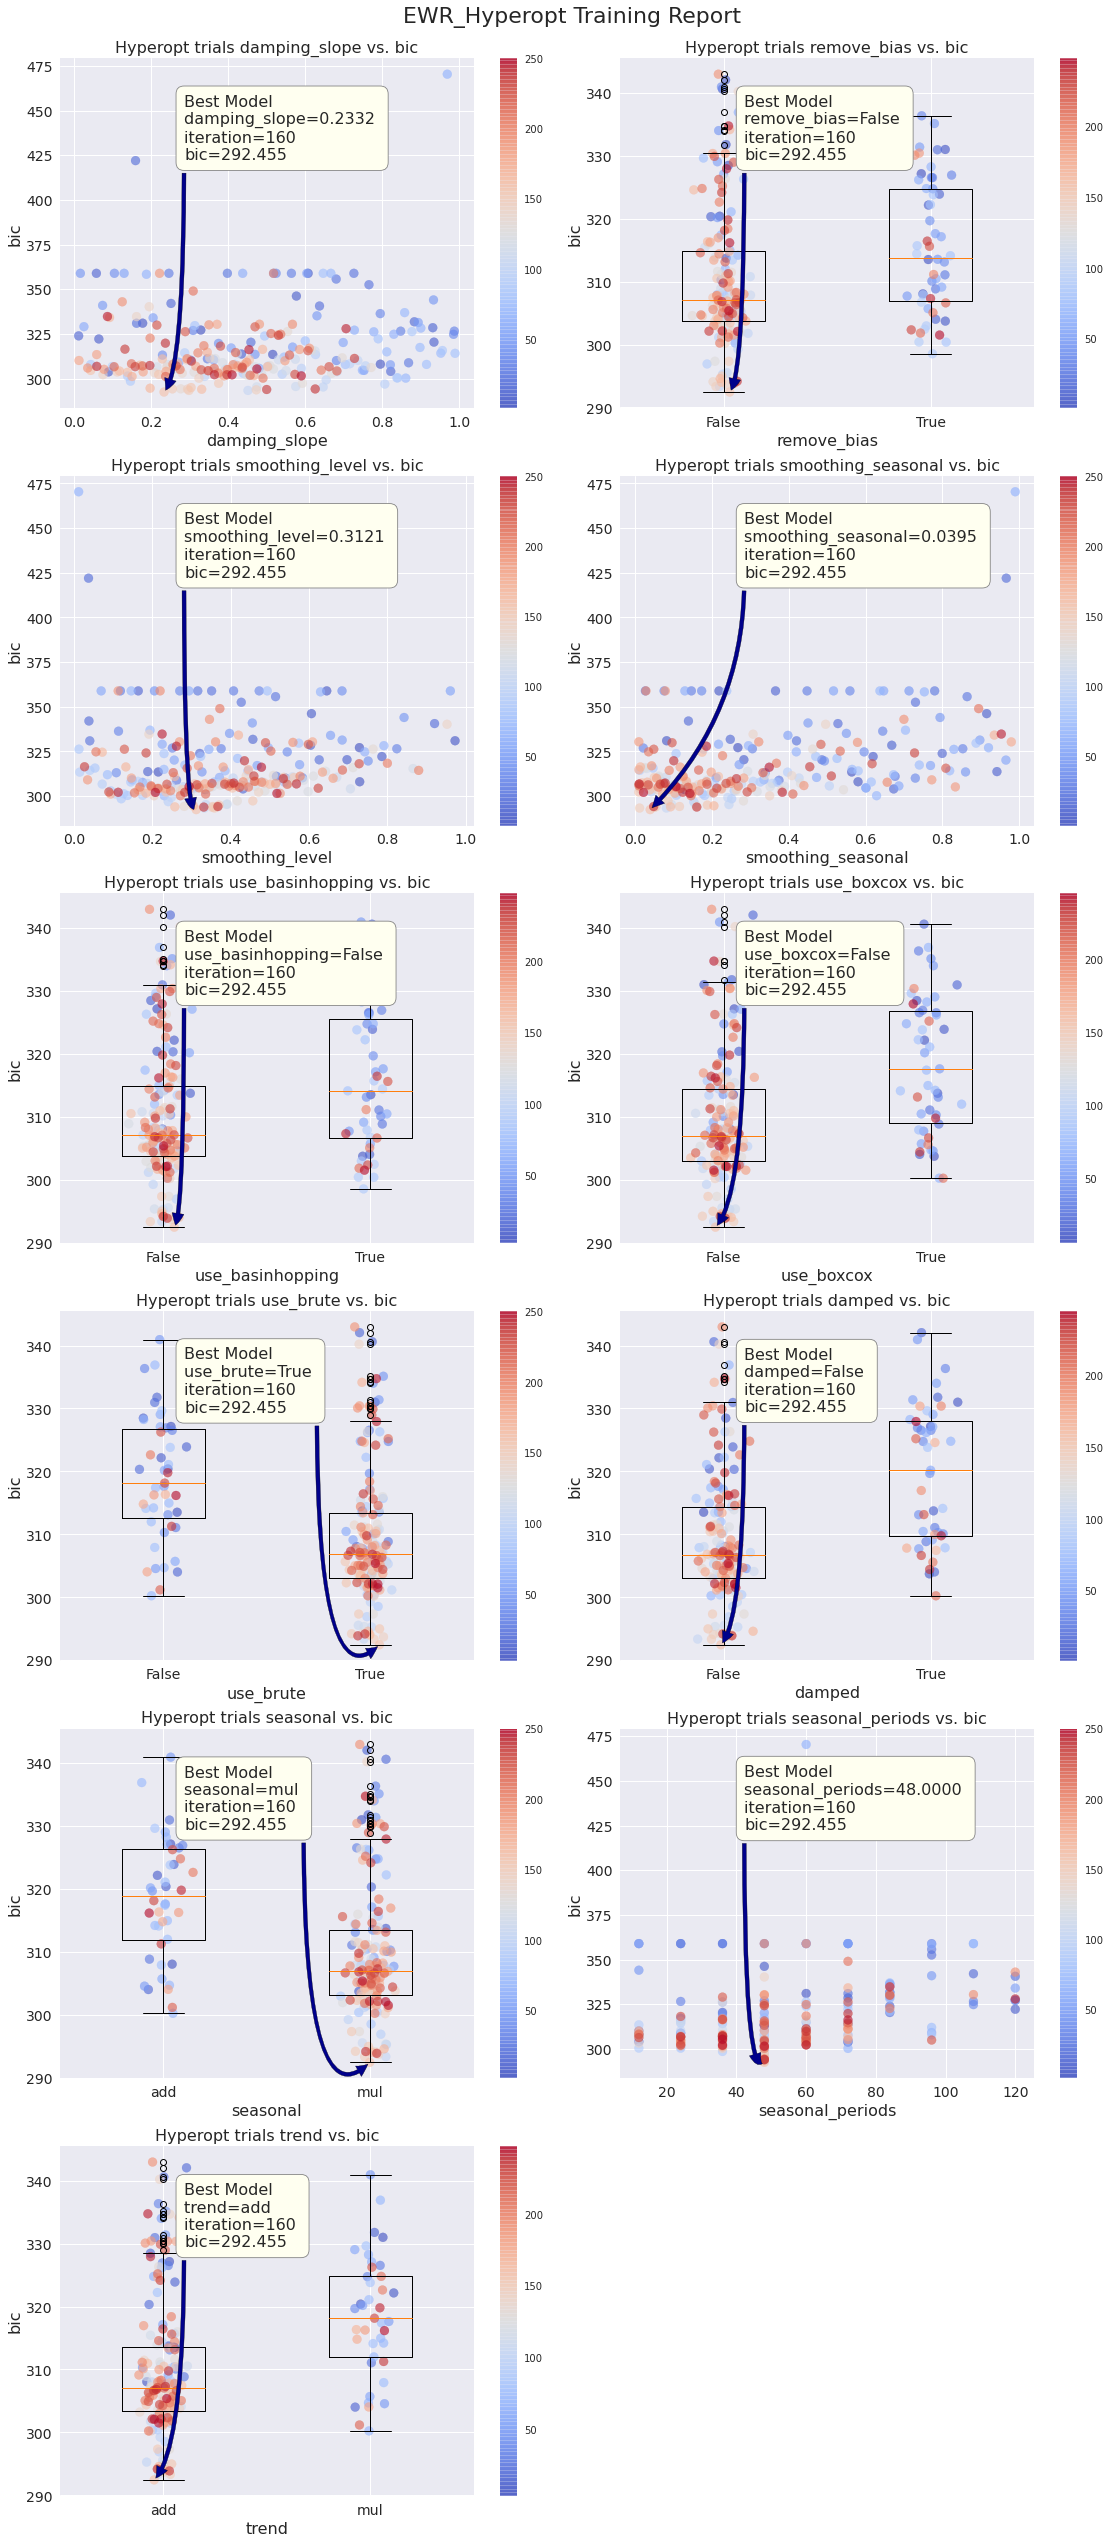

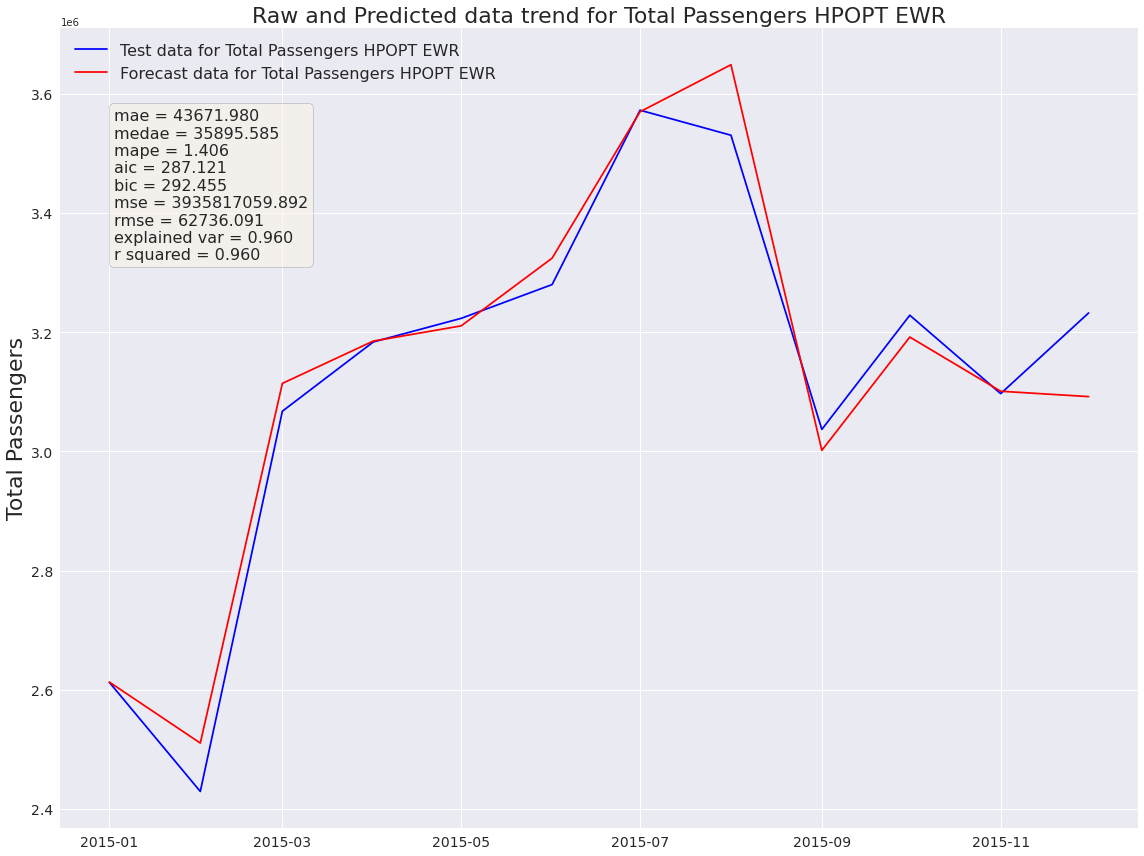

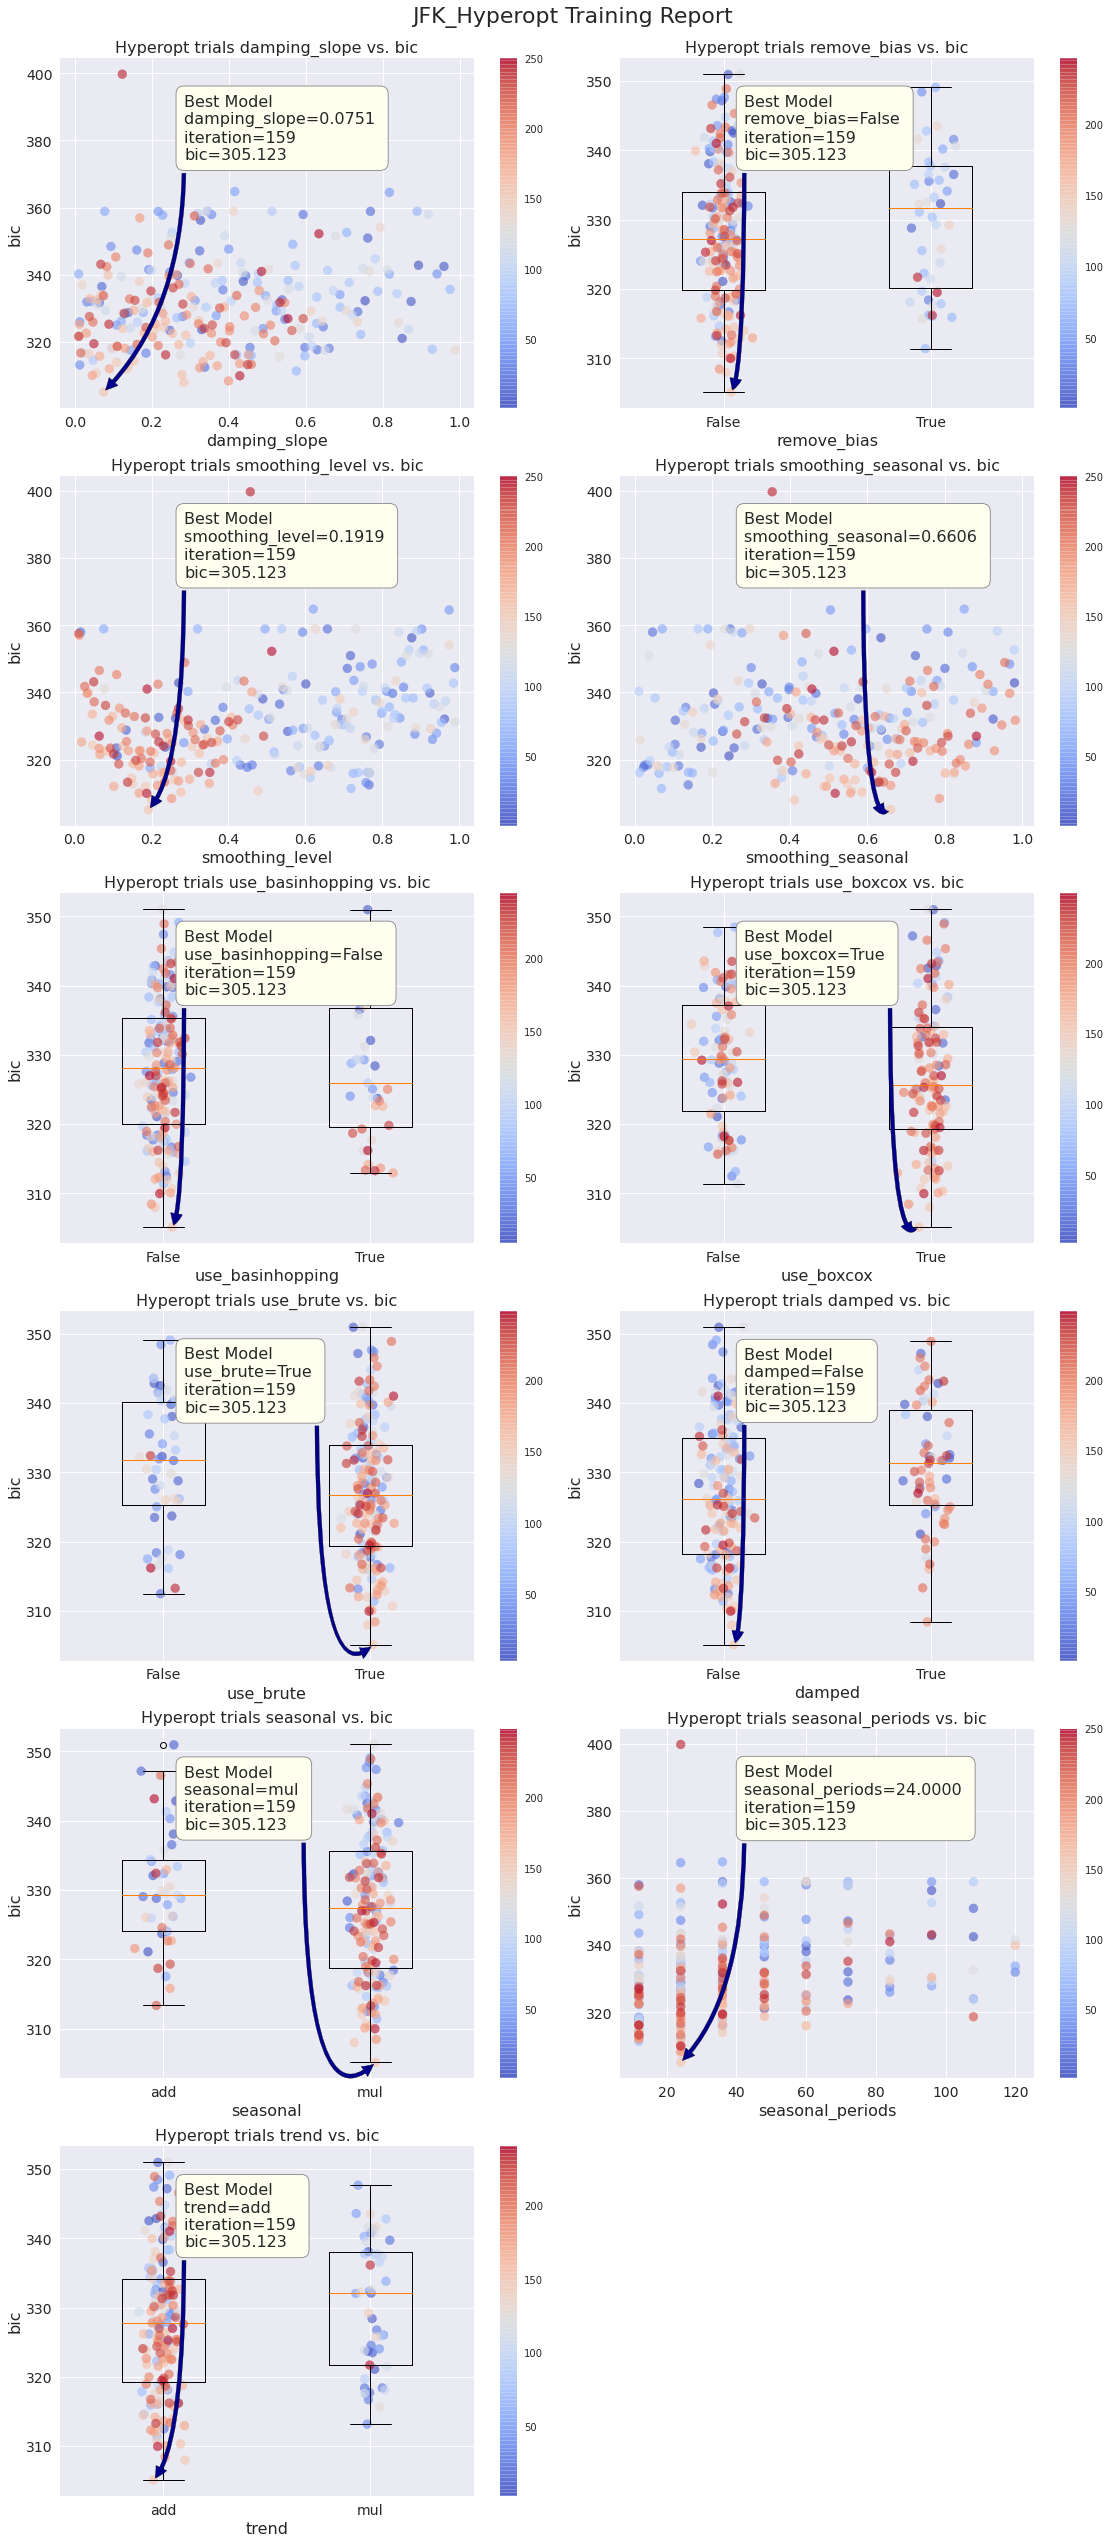

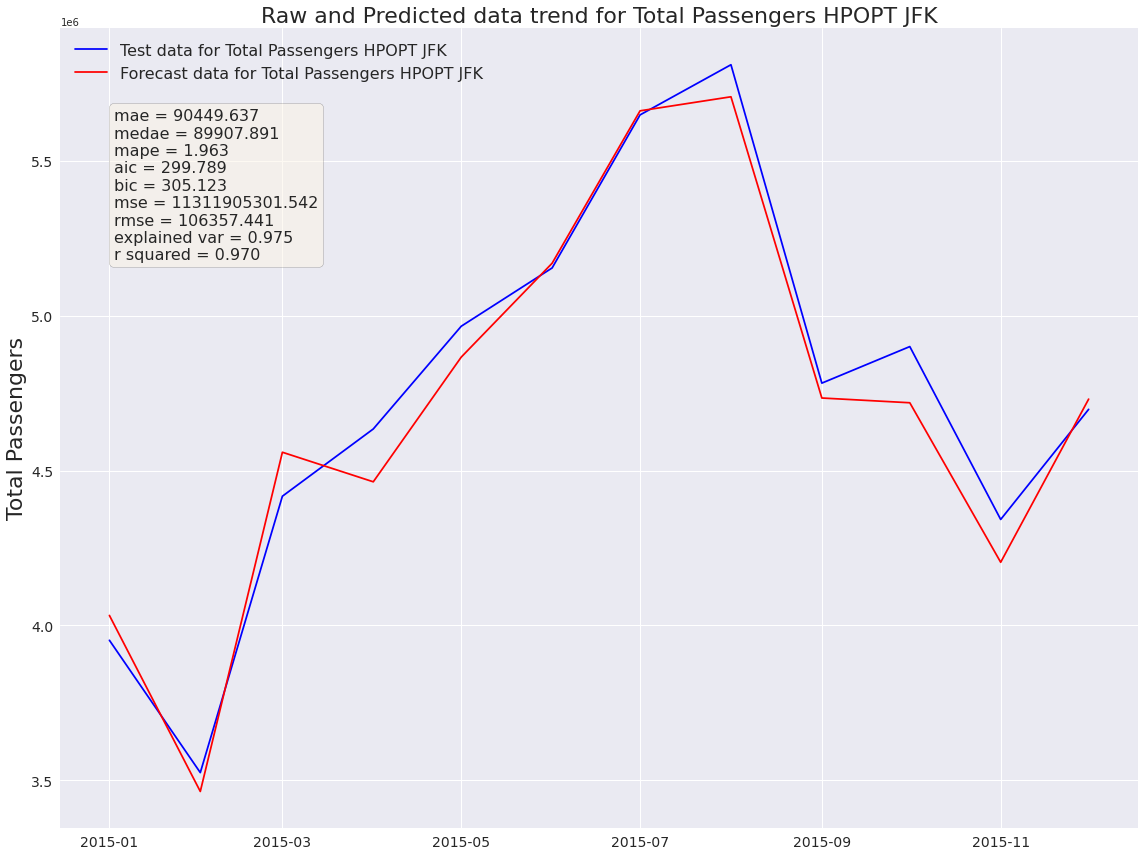

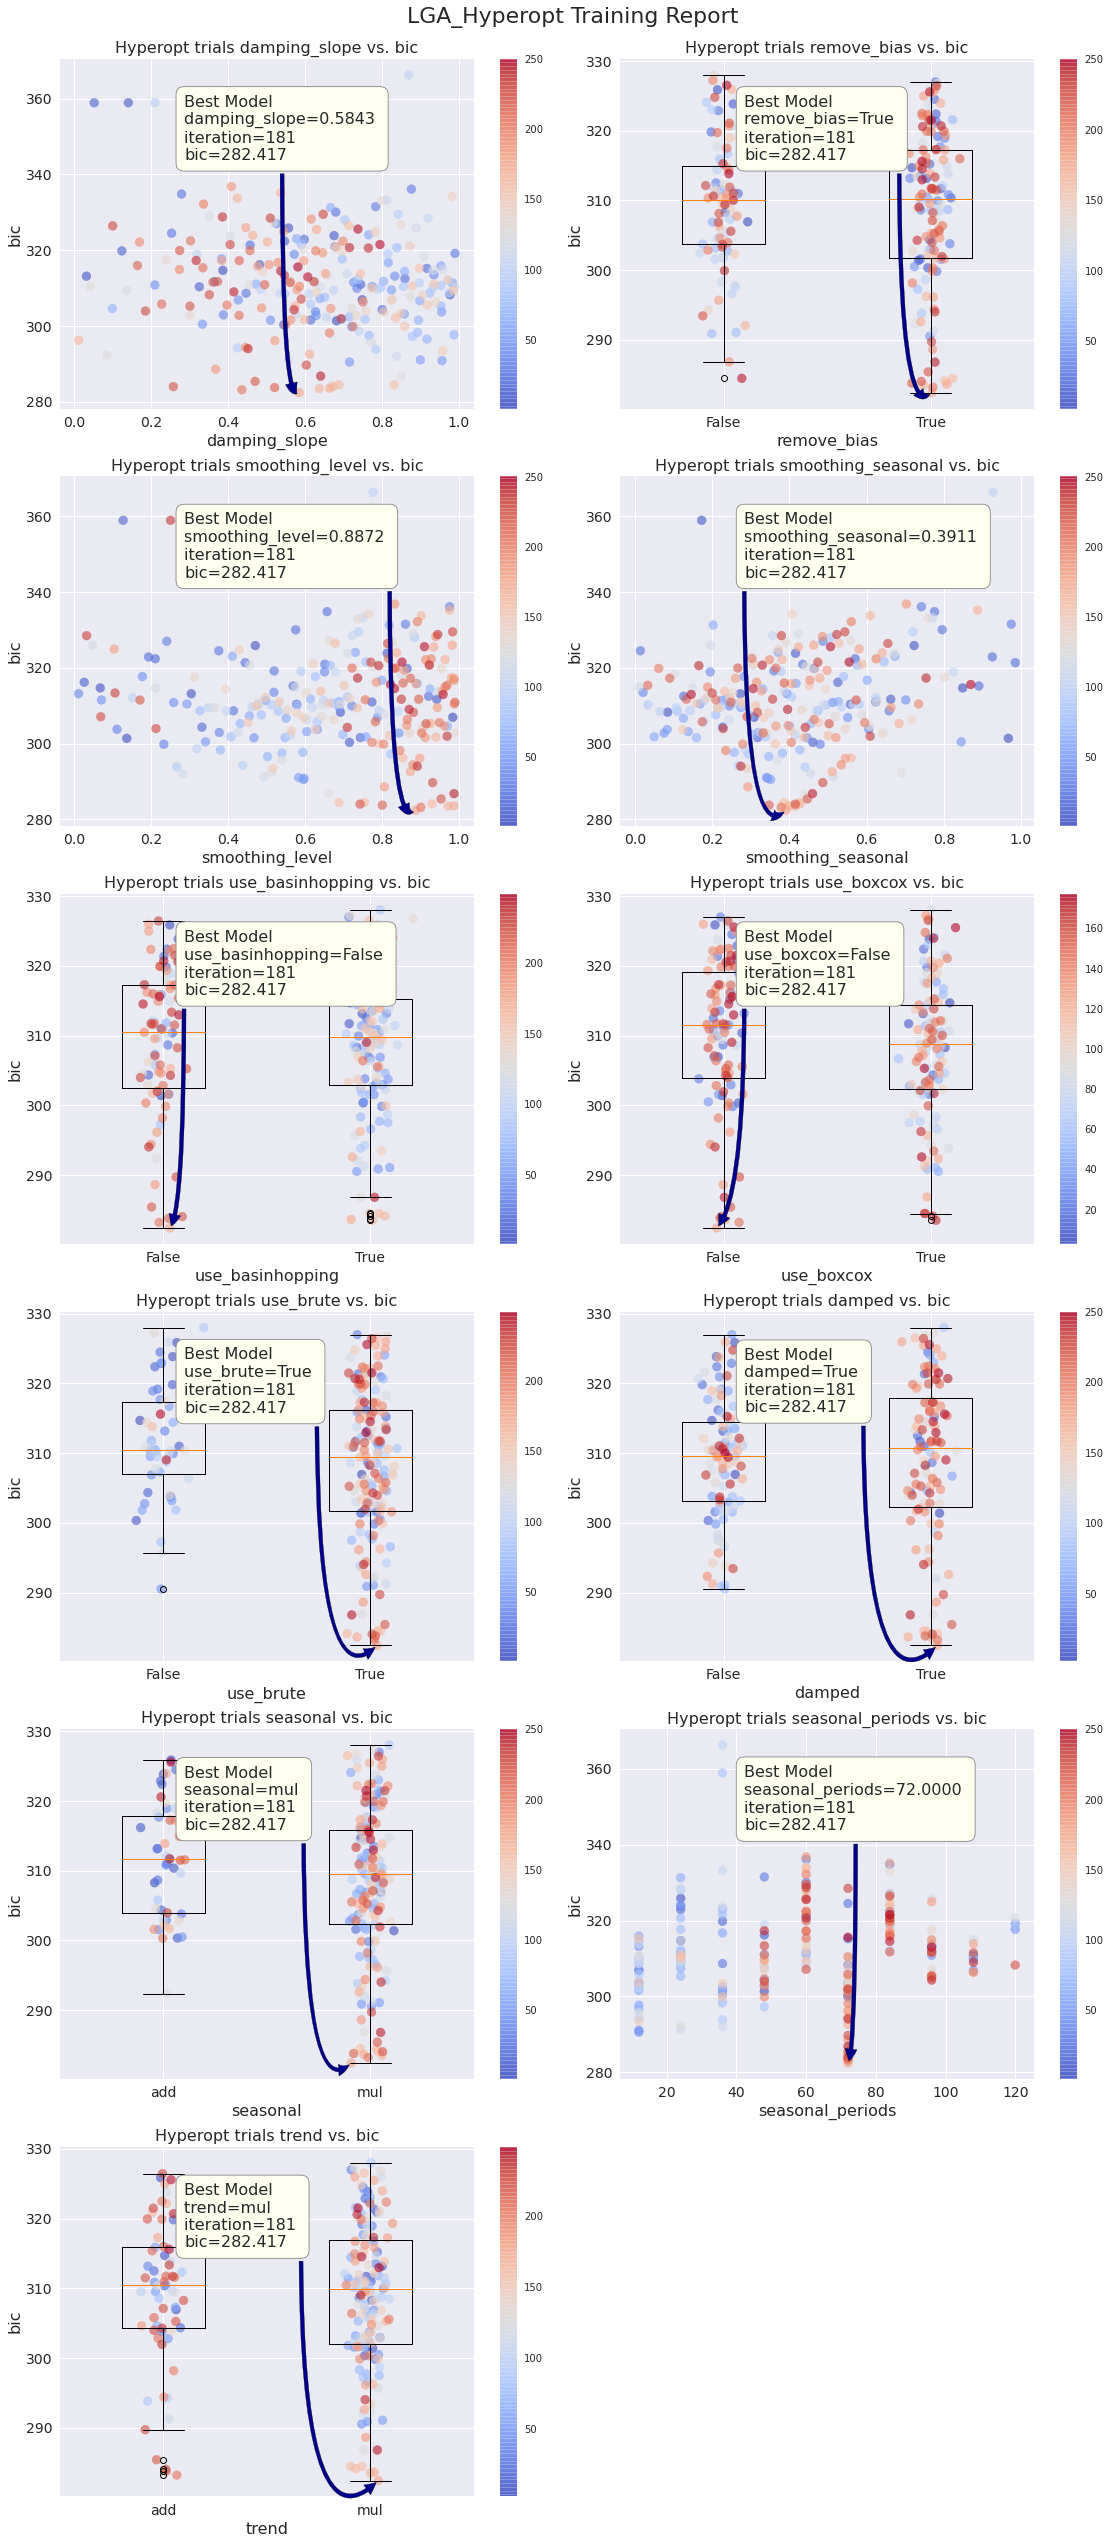

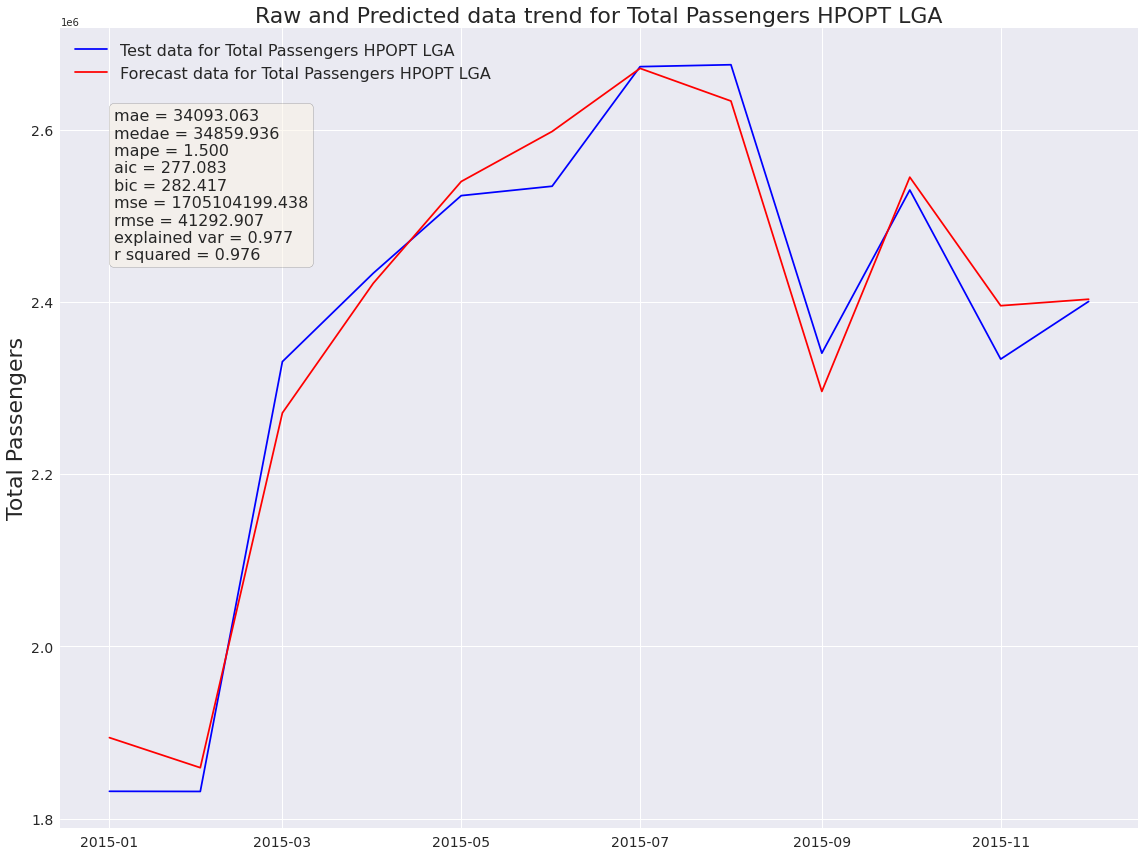

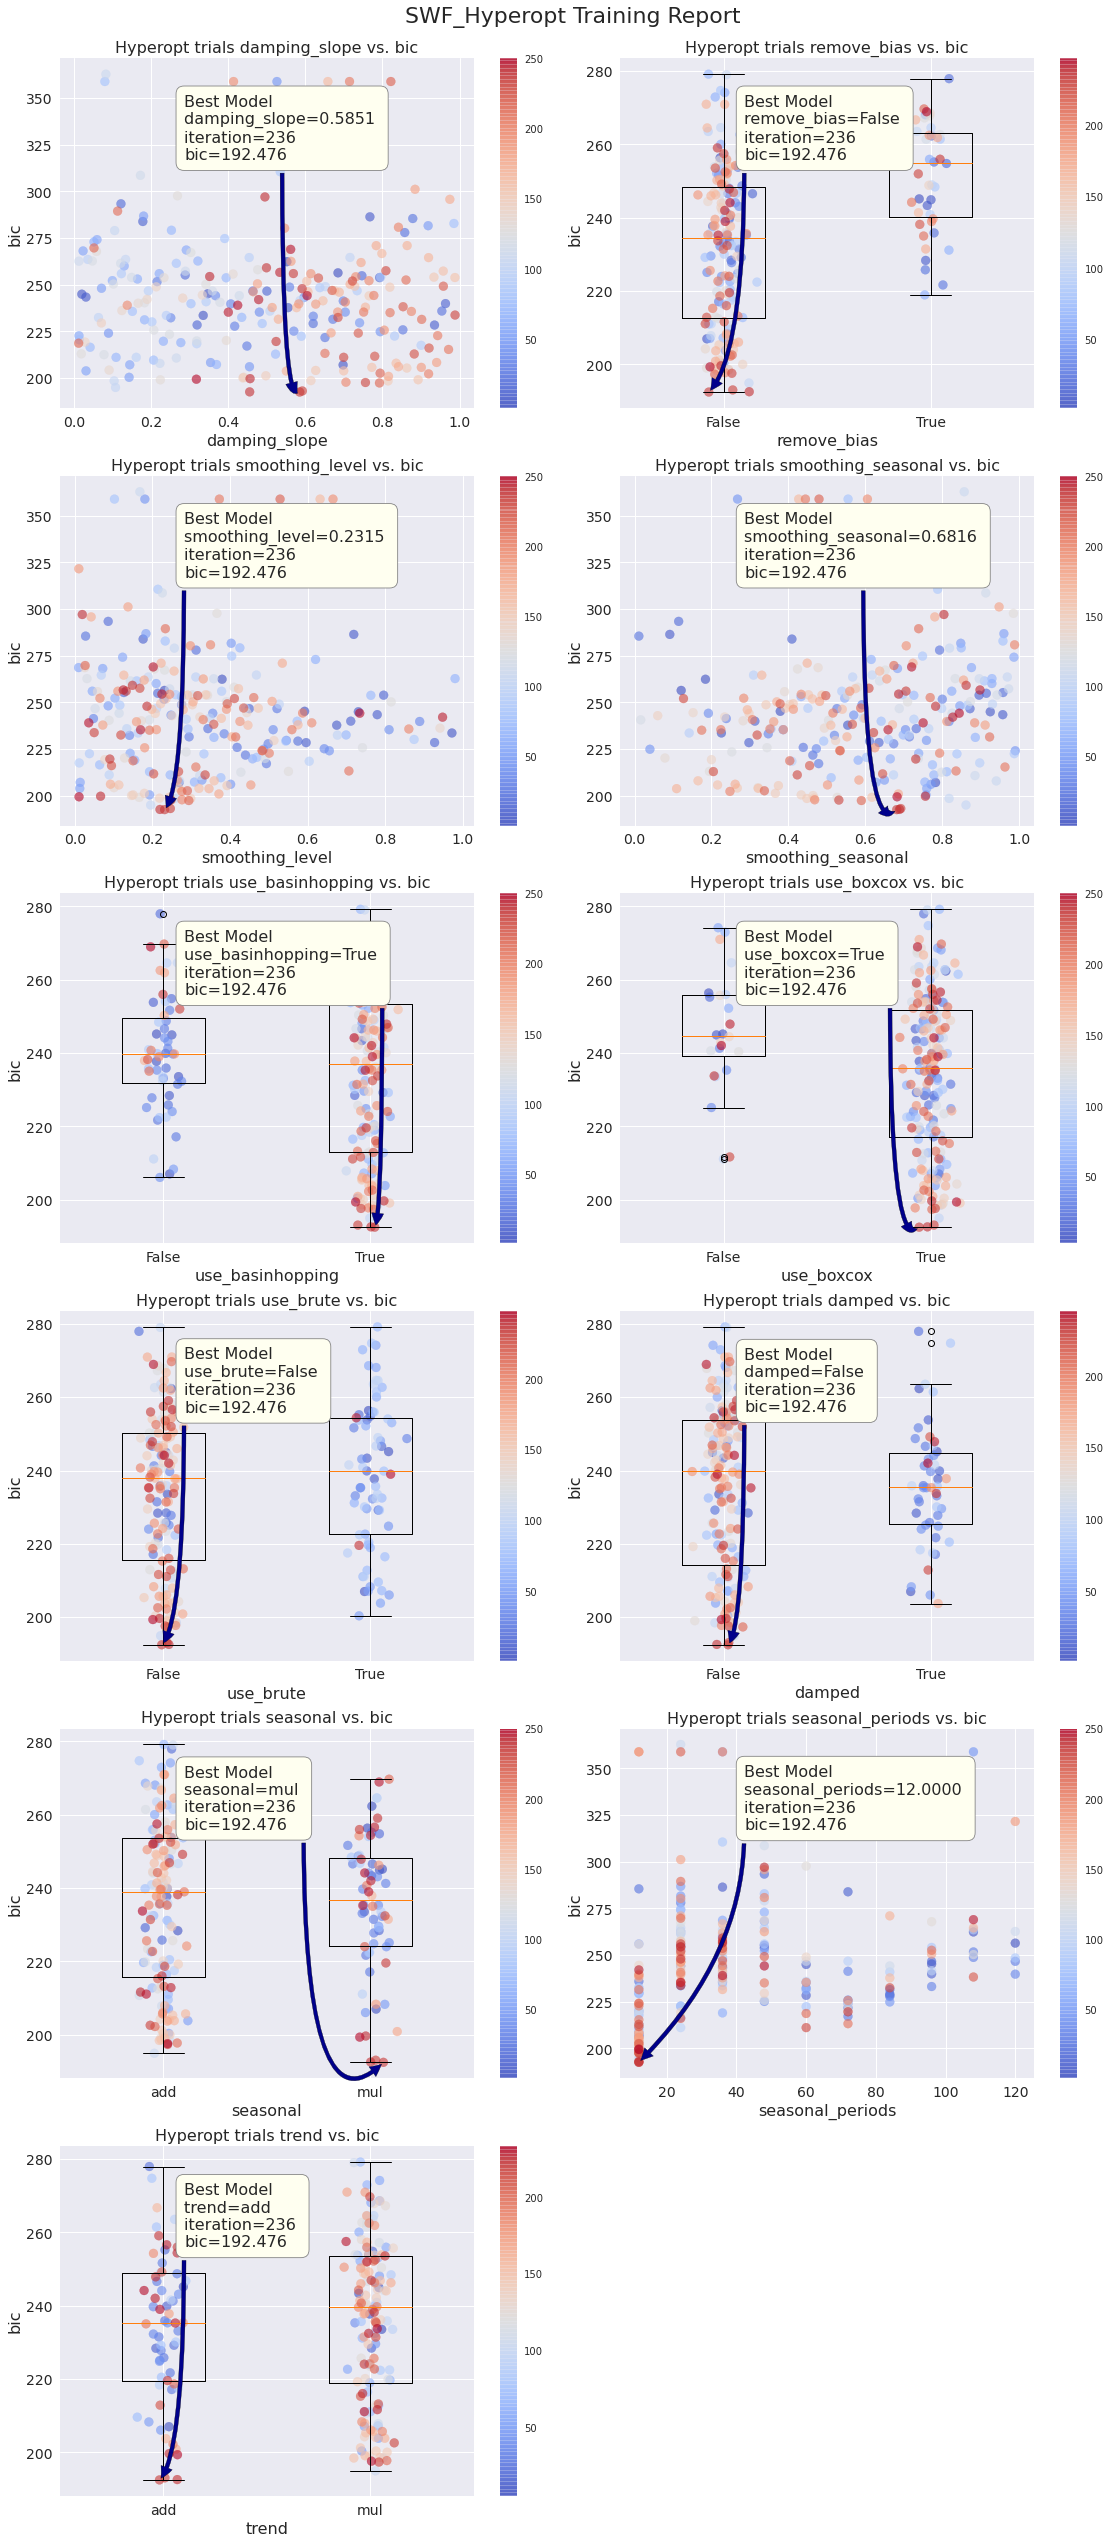

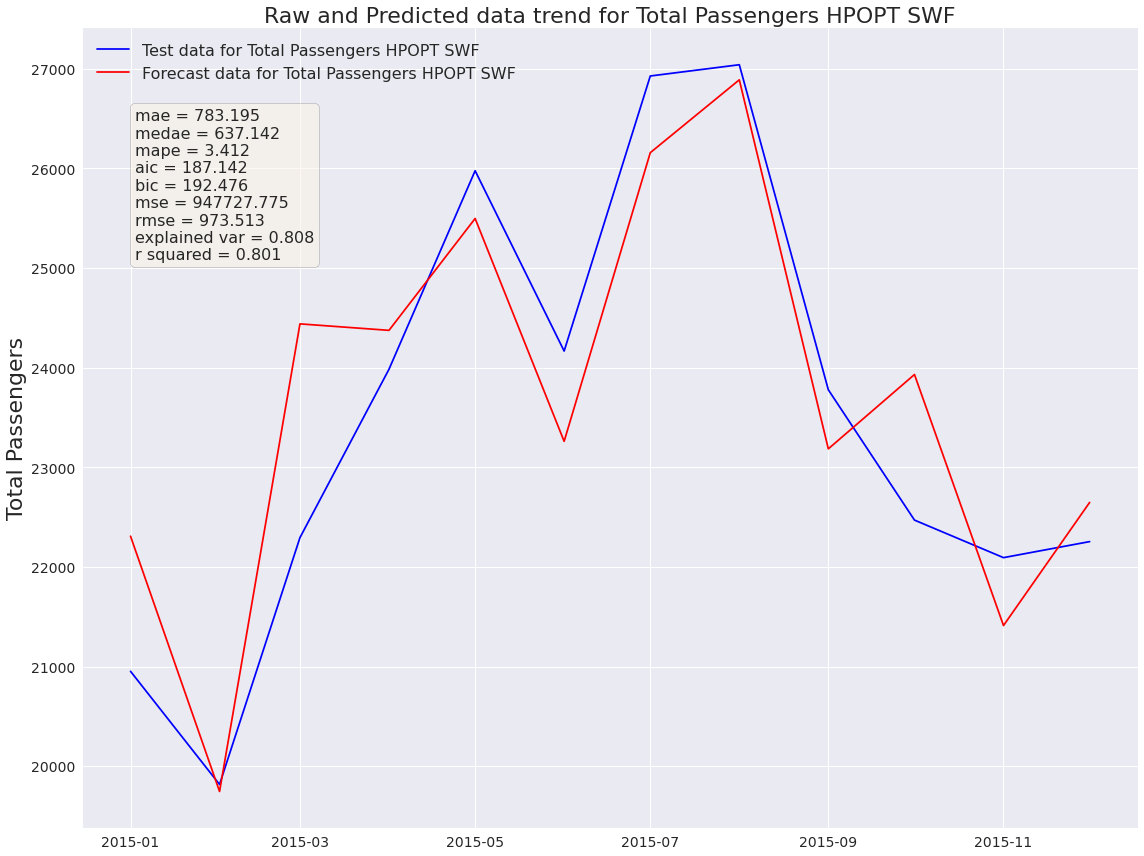

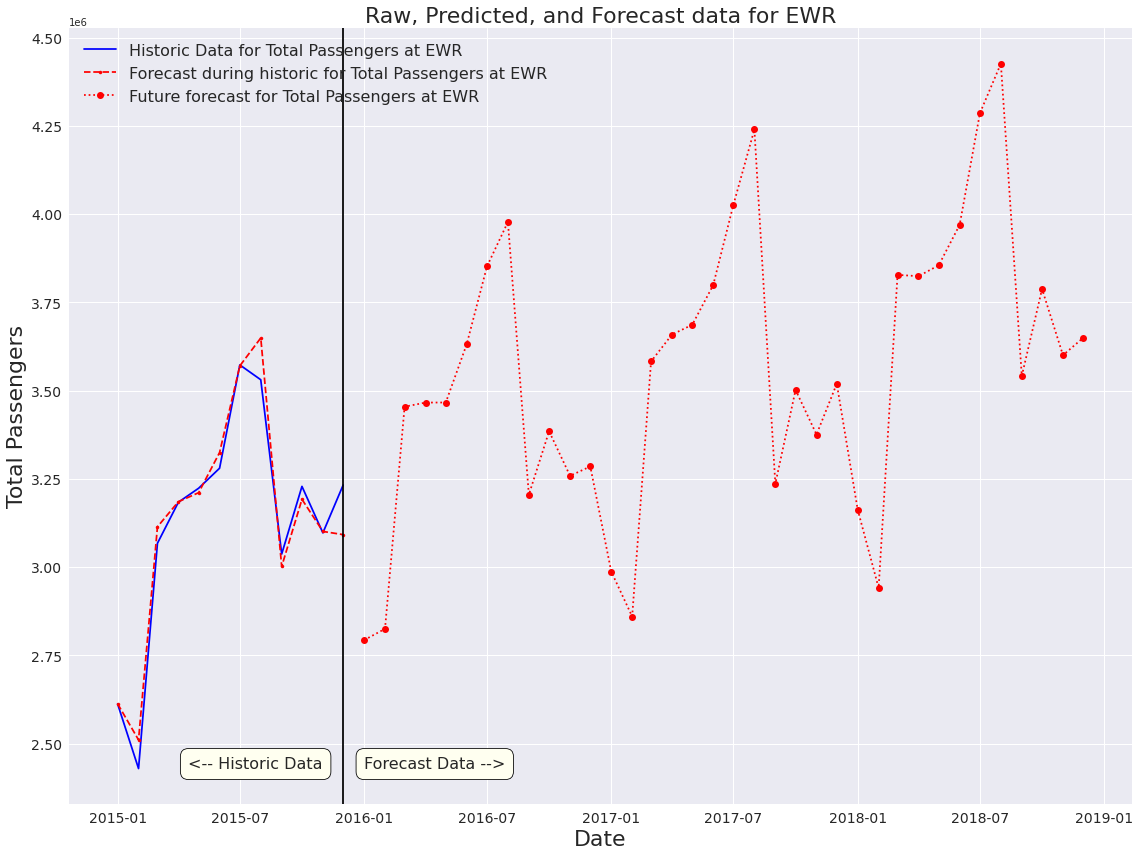

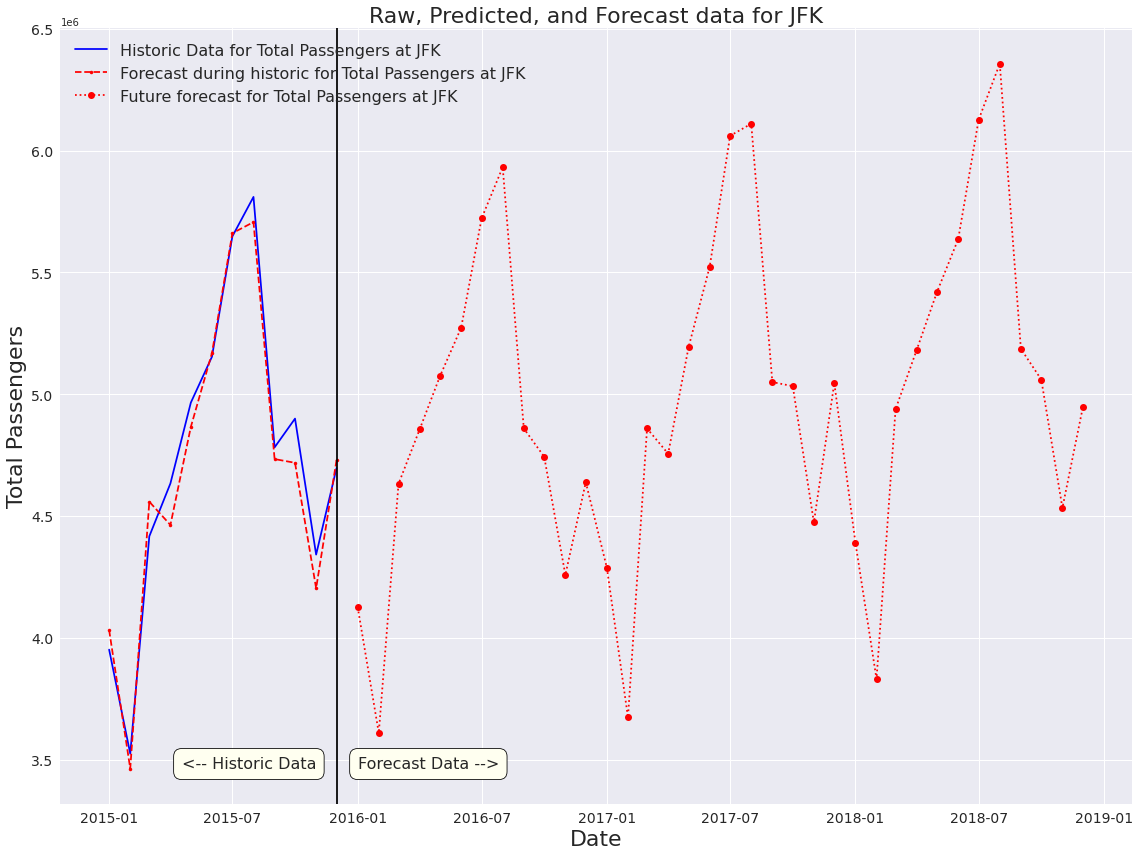

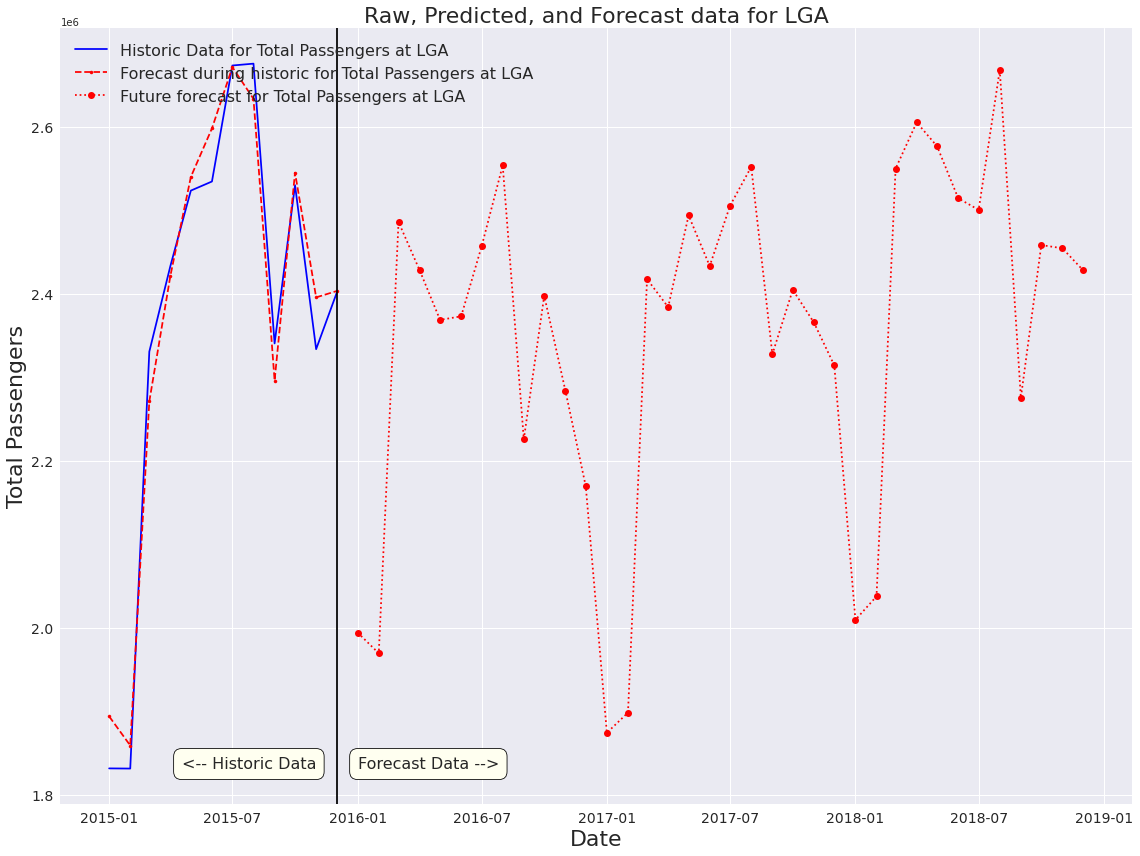

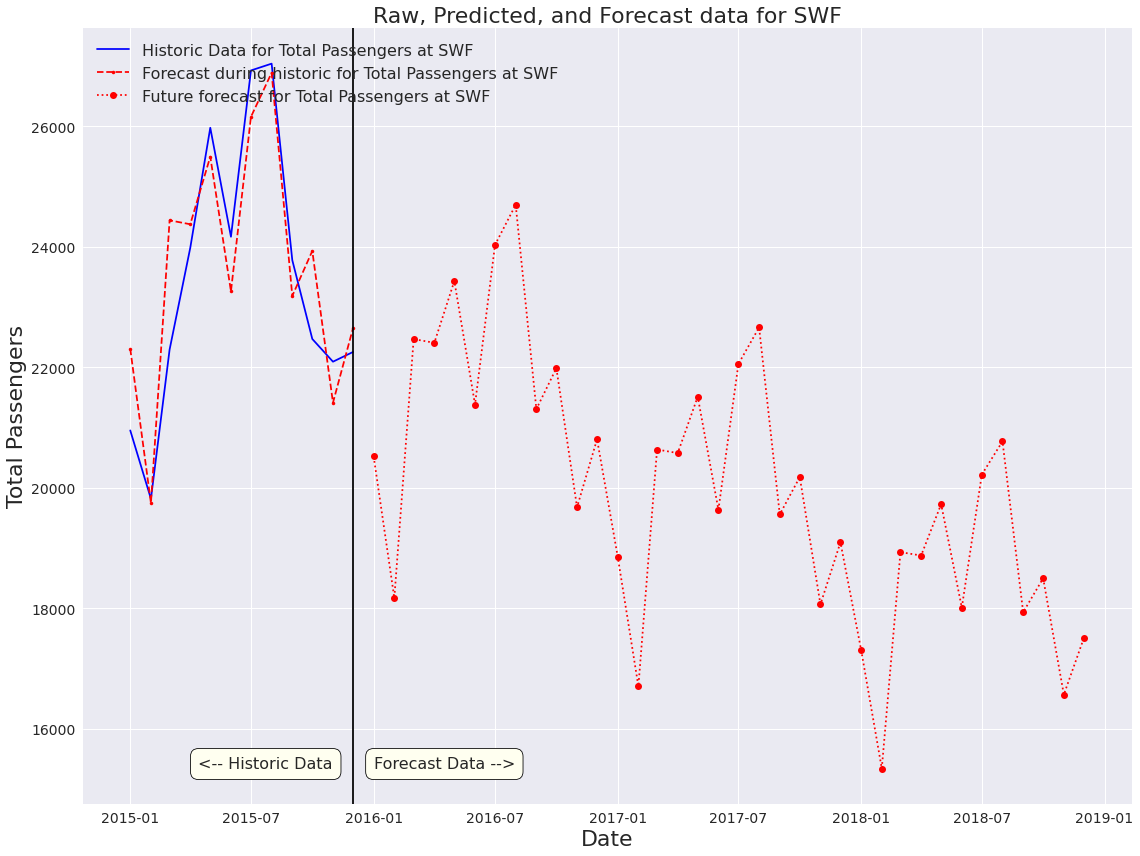

In [12]:
all_airports = run_all_models(**all_model_config)
all_forecasts = build_forecast_dataset(all_airports, **all_model_config)
forecast_plots = generate_forecast_plots(all_forecasts, **plot_conf)

<b><u>Let's take a look at the return type of run_all_models()</u></b> before we mention anything else...

In [13]:
all_airports

{'EWR': {'best_hp_params': {'fit': {'damping_slope': 0.23321063634168313,
    'remove_bias': False,
    'smoothing_level': 0.3121257551586863,
    'smoothing_seasonal': 0.039502581711991266,
    'use_basinhopping': False,
    'use_boxcox': False,
    'use_brute': True},
   'model': {'damped': False,
    'seasonal': 'mul',
    'seasonal_periods': 48.0,
    'trend': 'add'}},
  'best_model': <statsmodels.tsa.holtwinters.HoltWintersResultsWrapper at 0x7fedf4be9a60>,
  'hyperopt_trials_data':      TestID         bic  damping_slope  remove_bias  smoothing_level  \
  0         1  327.146295       0.328619         True         0.728523   
  1         2  313.513045       0.515484         True         0.215332   
  2         3  308.053544       0.795035         True         0.729198   
  3         4  331.002300       0.177645         True         0.972493   
  4         5  358.906227       0.607454         True         0.645121   
  ..      ...         ...            ...          ...            

Ok, that's a lot of stuff. A lot. of. stuff. in there.<br>
Why are we recording all of this?<br>
... so that we can have it to reference in the future, so that we can audit it when we move to production, and so that if we make significant alterations to the functionality of our code base, we can see how it performed before those modifications.<br>
Let's take a look at a single airport and see what is actually included in the dictionary...

In [14]:
all_airports['JFK']

{'best_hp_params': {'fit': {'damping_slope': 0.07509213473943524,
   'remove_bias': False,
   'smoothing_level': 0.1919317428540095,
   'smoothing_seasonal': 0.6606358212871597,
   'use_basinhopping': False,
   'use_boxcox': True,
   'use_brute': True},
  'model': {'damped': False,
   'seasonal': 'mul',
   'seasonal_periods': 24.0,
   'trend': 'add'}},
 'best_model': <statsmodels.tsa.holtwinters.HoltWintersResultsWrapper at 0x7fedf4b1f6d0>,
 'hyperopt_trials_data':      TestID         bic  damping_slope  remove_bias  smoothing_level  \
 0         1  332.305459       0.754461         True         0.262629   
 1         2  342.851799       0.893249        False         0.270626   
 2         3  321.088760       0.850950        False         0.110561   
 3         4  356.262788       0.326794        False         0.876809   
 4         5  342.522546       0.959514        False         0.601283   
 ..      ...         ...            ...          ...              ...   
 245     246  319.50

Looking at this structure we can see all of the major items that we might want to record for posterity's sake...
* `best_hp_params` ->  The best hyperparameters that were found from the run. We have these recorded in the exact format that our exp_smoothing_raw function would need in order to perform a prediction on an ad-hoc basis.
* `best_model` -> The best model artifact. This is the actual model that we can perform a `.predict(<start index value>, <end index value>`) directly upon. That might be useful, right?
* `hyperopt_trials_data` -> The historical record of the hyperopt tuning, extracted into a Pandas DataFrame.
* `hyperopt_trials_visualization` -> The matplotlib.pyplot visualization that we saved to disk. We could perhaps send it elsewhere other than our local HDD if we wanted, right?
* `forecast_data` -> The Pandas Series that contains the predicted values for the forecast period that overlaps the test period series data.
* `series_prediction` -> The forecast data from both the test period and the future period, along with a boolean field that we can filter on to get our overlap with the ground truth OR the future state by itself. 
* `plot_data` -> all of our metrics (not just the one that hyperopt was using to tune itself). These are pretty important, particularly if we want to, at some later point, switch to a different optimization metric in production.

#### A quick recap...
What did we see in the last few 'active execution' notebook cells?
1. When we're actually <i>using our code</i> it merely takes two configuration definitions (the dictionaries that were assembled before running the previous cell) and 3 lines of code: one for finding the best configuration for each airport's forecasting model, one for generating future-looking forecasts based on the best model configuration, and a final function execution for providing visualizations for the forecasts. 
2. Everything that we need to <u>control the behavior of the run</u> exists within the configuration. If we need to make adjustments to how the forecasts are generated, what metrics to optimize on, the names of saved files, or how the tuner searches through candidate space for hyperparameters, all we need to do is change the configs. At no point do we have to search back through a large scripted code base and make sure that we're over-writing hard-coded configurations. 
3. The code is laid out in such a way that will make it incredibly trivial to port this over to fully modularized code, allowing us to write unit tests for this code base, giving us piece of mind that subsequent modifications and improvements made to it will not cause unforeseen issues with the prediction quality.
4. Although this code is significantly better than the prototype scripts that we were dealing with in the last chapter, it still has a bit of a way to go. Look at how long it takes to run in the next cell.

### Look into what Hyperopt is doing with its tuning
In the initial block above where we ran the full auto-tuning and generated forecasts from the best models for each airport, we had verbosity turned off to help make that portion of the outputs much easier to read. <br>
In this next section, let's take a look at what is actually happening here. Each new dictionary output that is written to stdout when a candidate model's hyperparameter configuration is submitted will be printed out to stdout. Similarly, any failure to converge in the underlying model itself will be printed to stderr (the pink highlighted text) showing the reasons for why the model couldn't train itself properly. <br>
With many of the supervised learning (and deep learning) algorithms that are available, models typically don't have the ability to 'absolutely fail' and throw an exception based solely on the hyperparameters selected. Statistical models, on the other hand, most certainly can (and likely will) do this. Don't be alarmed at these - trust me, the APIs aren't broken (although your code may be); it just means that you need to search in a different space (or that your data is pretty much garbage and you might be using the wrong algorithm).<br>
Knowing all of this (and the reasons for why I turned off the reporting to stdout and stderr above), let's see what it looks like with verbose mode turned on, below.
>> Author's note: My apologies for how long this is going to take to scroll down in order to see the results.

In [15]:
# Change the value of the verbose flag while keeping everything else the same 
#  (and preserving the state of the original dictionary with a deepcopy that will break the object reference to the
#   original dictionary)
all_model_config2 = copy.deepcopy(all_model_config)
all_model_config2['base_config']['verbose'] = True

Starting tuning of Airport EWR


  1%|          | 3/250 [00:00<00:53,  4.60trial/s, best loss: 328.00311563708095]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



  7%|▋         | 17/250 [00:23<07:02,  1.81s/trial, best loss: 303.019976086612] 

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



  8%|▊         | 19/250 [00:25<05:40,  1.48s/trial, best loss: 303.019976086612]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 10%|▉         | 24/250 [00:26<01:42,  2.20trial/s, best loss: 303.019976086612]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 11%|█         | 27/250 [00:27<01:41,  2.20trial/s, best loss: 302.2581756525645] 

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 12%|█▏        | 29/250 [00:28<01:41,  2.17trial/s, best loss: 302.2581756525645]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 16%|█▌        | 39/250 [00:31<01:33,  2.26trial/s, best loss: 301.94800606582544]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 17%|█▋        | 42/250 [01:28<42:05, 12.14s/trial, best loss: 301.94800606582544]  

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0



 18%|█▊        | 46/250 [02:22<41:55, 12.33s/trial, best loss: 301.94800606582544]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0



 20%|█▉        | 49/250 [02:29<23:06,  6.90s/trial, best loss: 301.94800606582544]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 21%|██        | 53/250 [02:30<11:21,  3.46s/trial, best loss: 301.94800606582544]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 25%|██▍       | 62/250 [02:32<01:56,  1.61trial/s, best loss: 301.94800606582544]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 30%|██▉       | 74/250 [02:34<00:41,  4.25trial/s, best loss: 301.94800606582544]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 31%|███       | 78/250 [02:35<00:32,  5.30trial/s, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 32%|███▏      | 80/250 [02:35<00:31,  5.40trial/s, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0



 34%|███▎      | 84/250 [02:37<00:45,  3.67trial/s, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



 35%|███▍      | 87/250 [02:54<07:24,  2.73s/trial, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 36%|███▌      | 89/250 [02:56<04:39,  1.74s/trial, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



 38%|███▊      | 95/250 [03:25<16:29,  6.39s/trial, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



 41%|████      | 103/250 [03:48<05:41,  2.32s/trial, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 42%|████▏     | 105/250 [03:51<04:40,  1.93s/trial, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 43%|████▎     | 108/250 [03:52<02:35,  1.09s/trial, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 45%|████▌     | 113/250 [03:53<00:51,  2.67trial/s, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



 47%|████▋     | 118/250 [04:32<09:07,  4.15s/trial, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0



 49%|████▉     | 122/250 [04:57<10:44,  5.04s/trial, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:913: RuntimeWarning: overflow encountered in multiply
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:918: RuntimeWarning: overflow encountered in multiply
  (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi))) + \

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:915: RuntimeWarning: invalid value encountered in true_divide
  b[i] = (beta * detrend(lvls[i], lvls[i - 1])) + \

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:926: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:948: RuntimeWarning: invalid value encountered in true_divide
  slope = detrend(trend[:nobs], level)

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:950: RuntimeWarning: invalid value encountered in subt

 49%|████▉     | 123/250 [04:57<07:36,  3.59s/trial, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0



 51%|█████     | 127/250 [05:44<12:06,  5.91s/trial, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 52%|█████▏    | 129/250 [05:45<06:15,  3.11s/trial, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 54%|█████▎    | 134/250 [06:22<06:26,  3.33s/trial, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 54%|█████▍    | 135/250 [06:33<10:37,  5.54s/trial, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optim

 55%|█████▌    | 138/250 [07:55<39:40, 21.26s/trial, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 56%|█████▌    | 140/250 [08:45<40:08, 21.90s/trial, best loss: 295.63108188830046]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 57%|█████▋    | 143/250 [11:43<1:21:42, 45.82s/trial, best loss: 294.189246793563]  

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 58%|█████▊    | 146/250 [13:03<58:06, 33.52s/trial, best loss: 292.0050457131435] 

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 59%|█████▉    | 148/250 [13:44<48:49, 28.72s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 60%|█████▉    | 149/250 [14:18<51:01, 30.31s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 60%|██████    | 151/250 [15:07<44:57, 27.25s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 61%|██████    | 153/250 [15:44<39:33, 24.47s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 62%|██████▏   | 154/250 [16:02<35:51, 22.41s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 62%|██████▏   | 155/250 [16:40<43:05, 27.22s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 62%|██████▏   | 156/250 [17:02<39:57, 25.51s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 63%|██████▎   | 157/250 [17:39<45:12, 29.17s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 63%|██████▎   | 158/250 [18:01<41:13, 26.88s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 64%|██████▎   | 159/250 [18:37<44:41, 29.46s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 64%|██████▍   | 161/250 [18:59<31:31, 21.25s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 65%|██████▍   | 162/250 [19:37<38:29, 26.24s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 65%|██████▌   | 163/250 [19:58<35:35, 24.55s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 66%|██████▌   | 164/250 [20:35<40:46, 28.45s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 67%|██████▋   | 167/250 [21:33<35:06, 25.38s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 67%|██████▋   | 168/250 [21:57<34:04, 24.93s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 68%|██████▊   | 169/250 [22:38<40:09, 29.74s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 68%|██████▊   | 170/250 [22:57<35:18, 26.49s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 68%|██████▊   | 171/250 [23:33<38:29, 29.24s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 69%|██████▉   | 173/250 [23:59<28:33, 22.25s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 70%|███████   | 176/250 [24:36<23:03, 18.70s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 71%|███████   | 177/250 [24:57<23:16, 19.12s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 72%|███████▏  | 179/250 [25:35<24:52, 21.02s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 72%|███████▏  | 180/250 [25:54<23:47, 20.40s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 73%|███████▎  | 182/250 [26:33<24:22, 21.51s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 73%|███████▎  | 183/250 [26:58<25:18, 22.66s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 74%|███████▍  | 185/250 [27:42<26:17, 24.27s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 75%|███████▍  | 187/250 [28:05<19:38, 18.71s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 77%|███████▋  | 192/250 [29:04<14:34, 15.07s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 78%|███████▊  | 194/250 [29:45<18:15, 19.57s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 78%|███████▊  | 196/250 [30:44<22:51, 25.40s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 79%|███████▉  | 197/250 [31:06<21:30, 24.35s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 79%|███████▉  | 198/250 [31:44<24:38, 28.44s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 80%|████████  | 200/250 [32:06<17:02, 20.45s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 81%|████████  | 202/250 [32:56<18:04, 22.59s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 82%|████████▏ | 204/250 [33:32<16:43, 21.82s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 82%|████████▏ | 206/250 [33:51<11:59, 16.34s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 84%|████████▎ | 209/250 [34:14<08:20, 12.21s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 84%|████████▍ | 210/250 [34:52<13:24, 20.10s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 85%|████████▌ | 213/250 [35:52<13:19, 21.62s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 86%|████████▌ | 215/250 [36:48<15:05, 25.86s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 86%|████████▋ | 216/250 [37:09<13:45, 24.27s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 87%|████████▋ | 217/250 [37:45<15:21, 27.92s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 87%|████████▋ | 218/250 [38:11<14:33, 27.31s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 88%|████████▊ | 219/250 [38:31<12:55, 25.01s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 88%|████████▊ | 221/250 [38:52<09:01, 18.69s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 89%|████████▉ | 222/250 [39:09<08:25, 18.05s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 90%|████████▉ | 224/250 [39:46<08:36, 19.85s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 90%|█████████ | 225/250 [40:05<08:11, 19.68s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 90%|█████████ | 226/250 [40:36<09:16, 23.19s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 93%|█████████▎| 232/250 [41:04<03:08, 10.48s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 93%|█████████▎| 233/250 [41:33<04:34, 16.13s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 94%|█████████▍| 235/250 [41:57<03:45, 15.02s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 96%|█████████▌| 239/250 [43:10<02:57, 16.16s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 96%|█████████▌| 240/250 [43:47<03:45, 22.58s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 97%|█████████▋| 242/250 [44:46<03:34, 26.85s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 98%|█████████▊| 246/250 [45:07<00:50, 12.54s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



100%|█████████▉| 249/250 [45:44<00:15, 15.22s/trial, best loss: 292.0050457131435]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



100%|██████████| 250/250 [46:06<00:00, 11.07s/trial, best loss: 292.0050457131435]


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



Starting tuning of Airport JFK


  6%|▌         | 14/250 [00:14<02:37,  1.50trial/s, best loss: 316.928458686856] 

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



  7%|▋         | 18/250 [00:16<02:37,  1.47trial/s, best loss: 316.928458686856]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



  8%|▊         | 21/250 [00:18<02:02,  1.87trial/s, best loss: 316.928458686856]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

  9%|▉         | 23/250 [00:18<01:32,  2.45trial/s, best loss: 316.928458686856]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 10%|▉         | 24/250 [00:19<02:07,  1.77trial/s, best loss: 316.928458686856]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 10%|█         | 25/250 [00:21<03:23,  1.11trial/s, best loss: 316.928458686856]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:895: RuntimeWarning: invalid value encountered in power
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:898: RuntimeWarning: invalid value encountered in power
  (betac * dampen(b[i - 1], phi))

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:899: RuntimeWarning: invalid value encountered in power
  s[i + m - 1] = y_gamma[i - 1] / trended(lvls[i - 1], dampen(b[i - 1], phi)) + \

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:905: RuntimeWarning: invalid value encountered in power
  b[:nobs] = dampen(b[:nobs], phi)



 10%|█         | 26/250 [00:21<02:49,  1.32trial/s, best loss: 316.928458686856]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 11%|█         | 28/250 [00:22<02:25,  1.53trial/s, best loss: 316.928458686856]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 12%|█▏        | 31/250 [00:23<01:39,  2.20trial/s, best loss: 316.928458686856]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 13%|█▎        | 32/250 [00:24<02:34,  1.41trial/s, best loss: 316.928458686856]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 14%|█▎        | 34/250 [02:00<1:14:13, 20.62s/trial, best loss: 316.928458686856]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 16%|█▌        | 39/250 [03:10<37:51, 10.76s/trial, best loss: 316.5025028697739]  

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 19%|█▉        | 47/250 [03:11<06:36,  1.95s/trial, best loss: 316.5025028697739]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 20%|██        | 51/250 [03:12<03:36,  1.09s/trial, best loss: 316.5025028697739]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 21%|██        | 53/250 [03:13<02:47,  1.18trial/s, best loss: 316.5025028697739]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 26%|██▌       | 65/250 [04:04<26:27,  8.58s/trial, best loss: 315.37563086486927]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 26%|██▋       | 66/250 [04:05<18:58,  6.19s/trial, best loss: 315.37563086486927]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 27%|██▋       | 68/250 [04:06<09:58,  3.29s/trial, best loss: 314.34756556188165]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 28%|██▊       | 69/250 [04:06<07:29,  2.48s/trial, best loss: 314.34756556188165]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 28%|██▊       | 71/250 [04:07<04:23,  1.47s/trial, best loss: 314.34756556188165]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 30%|███       | 76/250 [04:10<01:57,  1.47trial/s, best loss: 314.34756556188165]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 31%|███       | 77/250 [04:10<01:53,  1.52trial/s, best loss: 314.34756556188165]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 32%|███▏      | 81/250 [04:24<06:25,  2.28s/trial, best loss: 314.34756556188165]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 36%|███▋      | 91/250 [04:31<01:04,  2.47trial/s, best loss: 311.7659717240042] 

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



 40%|███▉      | 99/250 [04:34<01:08,  2.20trial/s, best loss: 304.53760565990854]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



 43%|████▎     | 107/250 [04:47<02:50,  1.19s/trial, best loss: 304.53760565990854]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



 47%|████▋     | 117/250 [04:52<00:41,  3.17trial/s, best loss: 304.53760565990854]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



 50%|█████     | 126/250 [04:56<00:43,  2.85trial/s, best loss: 304.53760565990854]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



 59%|█████▉    | 148/250 [05:07<01:01,  1.65trial/s, best loss: 304.53760565990854]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



 63%|██████▎   | 157/250 [05:11<00:26,  3.49trial/s, best loss: 304.53760565990854]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



 66%|██████▌   | 165/250 [05:15<00:33,  2.53trial/s, best loss: 304.53760565990854]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



 80%|████████  | 200/250 [05:29<00:15,  3.23trial/s, best loss: 304.53760565990854]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



 86%|████████▋ | 216/250 [06:22<00:48,  1.43s/trial, best loss: 304.53760565990854]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



 94%|█████████▍| 235/250 [06:30<00:04,  3.19trial/s, best loss: 304.53760565990854]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



 96%|█████████▌| 239/250 [06:31<00:03,  2.82trial/s, best loss: 304.53760565990854]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



100%|██████████| 250/250 [07:00<00:00,  1.68s/trial, best loss: 304.53760565990854]

Starting tuning of Airport LGA


  4%|▍         | 10/250 [02:06<1:34:37, 23.66s/trial, best loss: 304.47049657449236]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



  6%|▌         | 15/250 [03:20<52:12, 13.33s/trial, best loss: 304.47049657449236]  

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

  6%|▋         | 16/250 [03:24<40:33, 10.40s/trial, best loss: 304.47049657449236]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

  7%|▋         | 17/250 [03:31<36:49,  9.48s/trial, best loss: 304.47049657449236]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



  7%|▋         | 18/250 [03:31<25:52,  6.69s/trial, best loss: 304.47049657449236]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 16%|█▋        | 41/250 [04:22<21:36,  6.20s/trial, best loss: 288.8006023051473] 

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 17%|█▋        | 42/250 [04:23<15:34,  4.49s/trial, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 22%|██▏       | 56/250 [05:14<08:11,  2.54s/trial, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 23%|██▎       | 57/250 [05:15<06:11,  1.92s/trial, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 28%|██▊       | 70/250 [05:18<01:04,  2.77trial/s, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 33%|███▎      | 82/250 [05:20<00:38,  4.31trial/s, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 36%|███▌      | 90/250 [05:57<10:49,  4.06s/trial, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 37%|███▋      | 92/250 [05:58<07:43,  2.93s/trial, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 38%|███▊      | 95/250 [05:59<03:10,  1.23s/trial, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 39%|███▉      | 97/250 [06:00<02:17,  1.11trial/s, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 47%|████▋     | 117/250 [06:05<00:50,  2.64trial/s, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 50%|█████     | 125/250 [06:14<01:26,  1.44trial/s, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 53%|█████▎    | 133/250 [06:37<06:07,  3.14s/trial, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 57%|█████▋    | 142/250 [07:08<07:42,  4.28s/trial, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 57%|█████▋    | 143/250 [07:09<05:51,  3.29s/trial, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 70%|██████▉   | 174/250 [07:25<00:24,  3.12trial/s, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 71%|███████   | 177/250 [07:29<01:30,  1.24s/trial, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 82%|████████▏ | 206/250 [08:17<03:12,  4.37s/trial, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 89%|████████▉ | 223/250 [09:19<00:55,  2.04s/trial, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 92%|█████████▏| 230/250 [09:20<00:09,  2.05trial/s, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 96%|█████████▋| 241/250 [09:58<00:48,  5.37s/trial, best loss: 288.8006023051473]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



100%|██████████| 250/250 [09:59<00:00,  2.40s/trial, best loss: 288.8006023051473]

Starting tuning of Airport SWF


  0%|          | 0/250 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

  0%|          | 1/250 [00:02<10:11,  2.46s/trial, best loss: 358.9062265388106]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:913: RuntimeWarning: invalid value encountered in power
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:916: RuntimeWarning: invalid value encountered in power
  (betac * dampen(b[i - 1], phi))

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:918: RuntimeWarning: invalid value encountered in power
  (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi))) + \

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:924: RuntimeWarning: invalid value encountered in power
  b[:nobs] = dampen(b[:nobs], phi)



  2%|▏         | 5/250 [00:43<52:23, 12.83s/trial, best loss: 230.6619415441868]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



  2%|▏         | 6/250 [00:44<36:55,  9.08s/trial, best loss: 230.6619415441868]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



  4%|▎         | 9/250 [00:48<27:05,  6.74s/trial, best loss: 230.6619415441868]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



  4%|▍         | 10/250 [01:20<57:13, 14.31s/trial, best loss: 230.6619415441868]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



  7%|▋         | 18/250 [01:28<11:53,  3.08s/trial, best loss: 227.5091683558661]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:913: RuntimeWarning: invalid value encountered in power
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:916: RuntimeWarning: invalid value encountered in power
  (betac * dampen(b[i - 1], phi))

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:918: RuntimeWarning: invalid value encountered in power
  (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi))) + \

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:924: RuntimeWarning: invalid value encountered in power
  b[:nobs] = dampen(b[:nobs], phi)



 14%|█▎        | 34/250 [03:18<10:10,  2.83s/trial, best loss: 206.13835807396396] 

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 15%|█▌        | 38/250 [03:51<26:44,  7.57s/trial, best loss: 206.13835807396396]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 17%|█▋        | 42/250 [04:03<18:42,  5.40s/trial, best loss: 206.13835807396396]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 18%|█▊        | 45/250 [04:09<11:14,  3.29s/trial, best loss: 206.13835807396396]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 19%|█▉        | 48/250 [04:26<17:44,  5.27s/trial, best loss: 206.13835807396396]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 21%|██        | 53/250 [04:56<18:37,  5.67s/trial, best loss: 206.13835807396396]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 22%|██▏       | 55/250 [05:07<19:47,  6.09s/trial, best loss: 206.13835807396396]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 24%|██▎       | 59/250 [05:21<16:15,  5.11s/trial, best loss: 201.63188896609483]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 32%|███▏      | 80/250 [06:26<04:43,  1.67s/trial, best loss: 200.28514615715977]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 33%|███▎      | 82/250 [06:52<18:20,  6.55s/trial, best loss: 200.28514615715977]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 34%|███▍      | 85/250 [06:58<09:51,  3.58s/trial, best loss: 200.28514615715977]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 36%|███▌      | 90/250 [07:14<10:27,  3.92s/trial, best loss: 200.28514615715977]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < l

 40%|███▉      | 99/250 [08:03<13:33,  5.39s/trial, best loss: 200.28514615715977]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < l

 42%|████▏     | 104/250 [08:34<15:19,  6.30s/trial, best loss: 200.28514615715977]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 44%|████▎     | 109/250 [09:06<18:42,  7.96s/trial, best loss: 200.28514615715977]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub

 46%|████▌     | 114/250 [09:32<11:49,  5.21s/trial, best loss: 200.28514615715977]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optim

 48%|████▊     | 120/250 [10:21<13:45,  6.35s/trial, best loss: 200.28514615715977]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 50%|█████     | 126/250 [10:40<12:23,  5.99s/trial, best loss: 198.78917386228483]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 56%|█████▌    | 140/250 [11:06<01:41,  1.09trial/s, best loss: 197.634301851801]  

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 56%|█████▋    | 141/250 [11:07<02:01,  1.11s/trial, best loss: 197.634301851801]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:895: RuntimeWarning: invalid value encountered in power
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:898: RuntimeWarning: invalid value encountered in power
  (betac * dampen(b[i - 1], phi))

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:899: RuntimeWarning: invalid value encountered in power
  s[i + m - 1] = y_gamma[i - 1] / trended(lvls[i - 1], dampen(b[i - 1], phi)) + \

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:905: RuntimeWarning: invalid value encountered in power
  b[:nobs] = dampen(b[:nobs], phi)



 62%|██████▏   | 155/250 [12:16<03:24,  2.15s/trial, best loss: 196.04120743143716]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 63%|██████▎   | 157/250 [12:19<02:49,  1.82s/trial, best loss: 196.04120743143716]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:895: RuntimeWarning: overflow encountered in multiply
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:899: RuntimeWarning: overflow encountered in multiply
  s[i + m - 1] = y_gamma[i - 1] / trended(lvls[i - 1], dampen(b[i - 1], phi)) + \

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:897: RuntimeWarning: invalid value encountered in true_divide
  b[i] = (beta * detrend(lvls[i], lvls[i - 1])) + \

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:907: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinte

 66%|██████▌   | 164/250 [13:03<06:38,  4.64s/trial, best loss: 196.04120743143716]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 67%|██████▋   | 168/250 [13:08<03:03,  2.24s/trial, best loss: 196.04120743143716]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 70%|██████▉   | 174/250 [13:09<00:39,  1.93trial/s, best loss: 196.04120743143716]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 75%|███████▍  | 187/250 [13:11<00:10,  6.11trial/s, best loss: 194.6926991359553] 

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 77%|███████▋  | 193/250 [13:11<00:08,  6.69trial/s, best loss: 194.6926991359553]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 78%|███████▊  | 196/250 [13:12<00:10,  5.32trial/s, best loss: 194.6926991359553]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 79%|███████▉  | 198/250 [13:12<00:09,  5.30trial/s, best loss: 194.6926991359553]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 82%|████████▏ | 206/250 [13:13<00:05,  7.78trial/s, best loss: 194.6926991359553]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 84%|████████▍ | 210/250 [13:14<00:05,  7.07trial/s, best loss: 194.6926991359553]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 85%|████████▍ | 212/250 [13:15<00:08,  4.67trial/s, best loss: 194.6926991359553]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",



 86%|████████▋ | 216/250 [13:16<00:08,  3.97trial/s, best loss: 194.6926991359553]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 89%|████████▉ | 222/250 [13:17<00:06,  4.34trial/s, best loss: 194.6926991359553]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 93%|█████████▎| 232/250 [13:51<00:22,  1.25s/trial, best loss: 194.6926991359553]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx



 95%|█████████▌| 238/250 [13:56<00:10,  1.16trial/s, best loss: 194.6926991359553]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:63: RuntimeWarning: invalid value encountered in greater
  violated = (x < lb) | (x > ub)

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:64: RuntimeWarning: invalid value encountered in less_equal
  fitting = np.abs(h_total) <= np.maximum(lower_dist, upper_dist)

/o

 96%|█████████▌| 240/250 [13:56<00:06,  1.45trial/s, best loss: 194.6926991359553]

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:895: RuntimeWarning: invalid value encountered in power
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:898: RuntimeWarning: invalid value encountered in power
  (betac * dampen(b[i - 1], phi))

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:899: RuntimeWarning: invalid value encountered in power
  s[i + m - 1] = y_gamma[i - 1] / trended(lvls[i - 1], dampen(b[i - 1], phi)) + \

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:905: RuntimeWarning: invalid value encountered in power
  b[:nobs] = dampen(b[:nobs], phi)



 99%|█████████▉| 248/250 [14:53<00:32, 16.06s/trial, best loss: 194.6926991359553]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0



100%|██████████| 250/250 [15:00<00:00,  3.60s/trial, best loss: 194.6926991359553]

CPU times: user 1h 13min 25s, sys: 19.8 s, total: 1h 13min 44s
Wall time: 1h 18min 59s


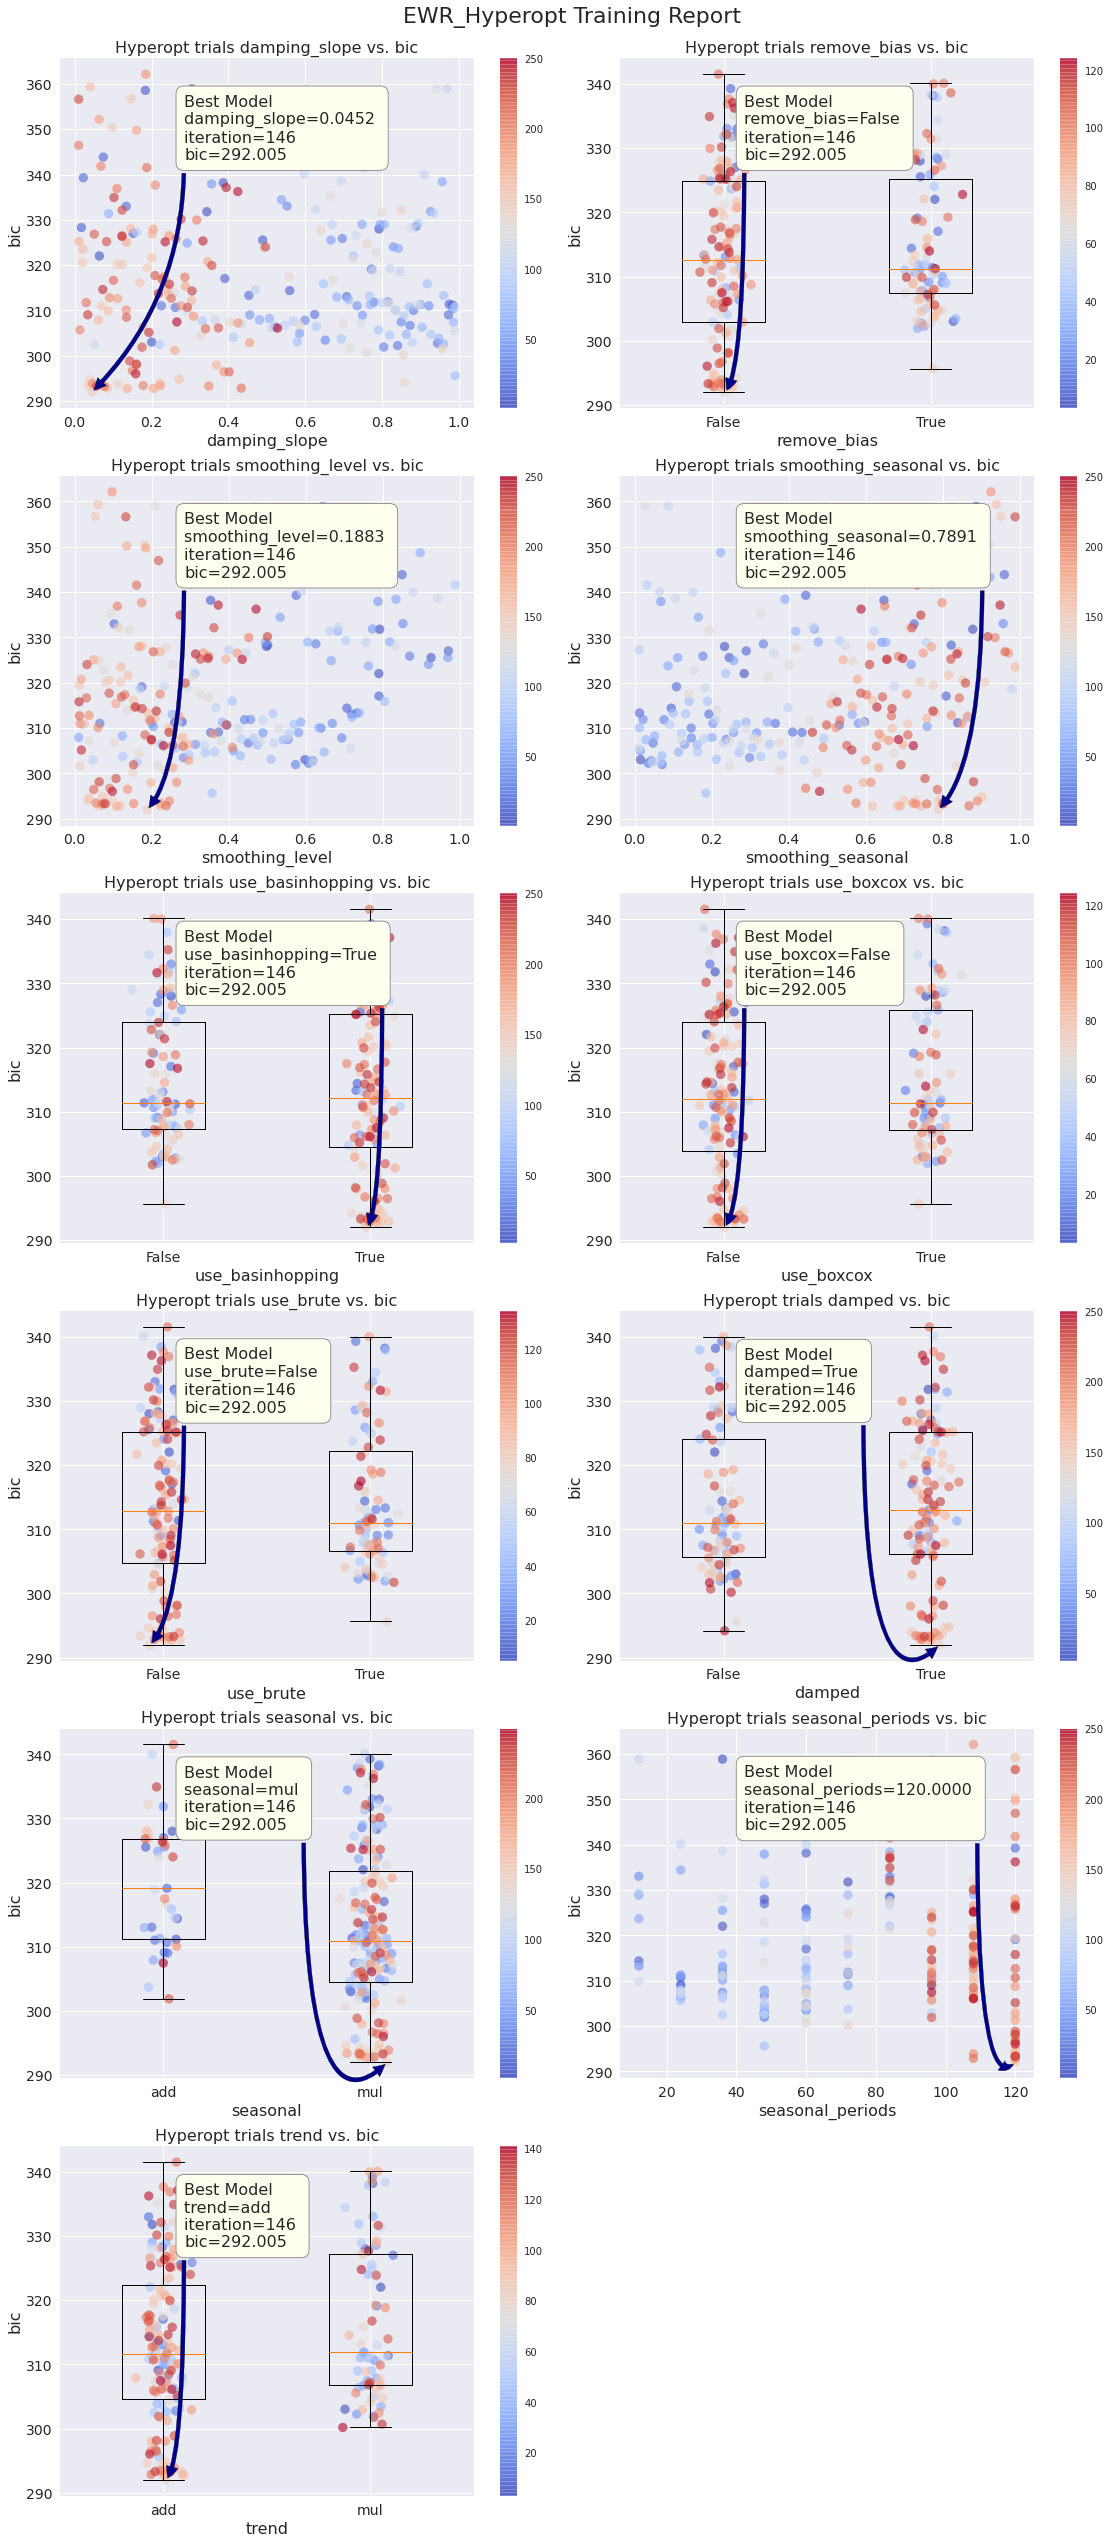

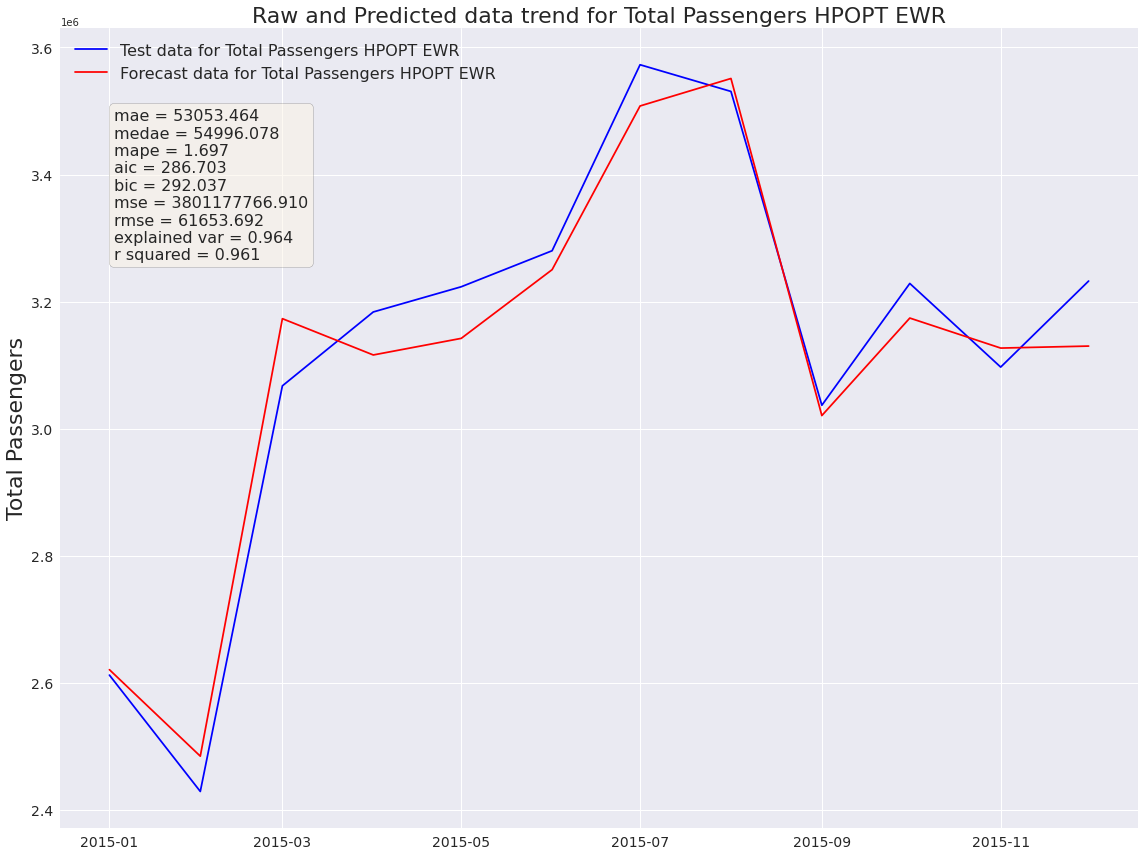

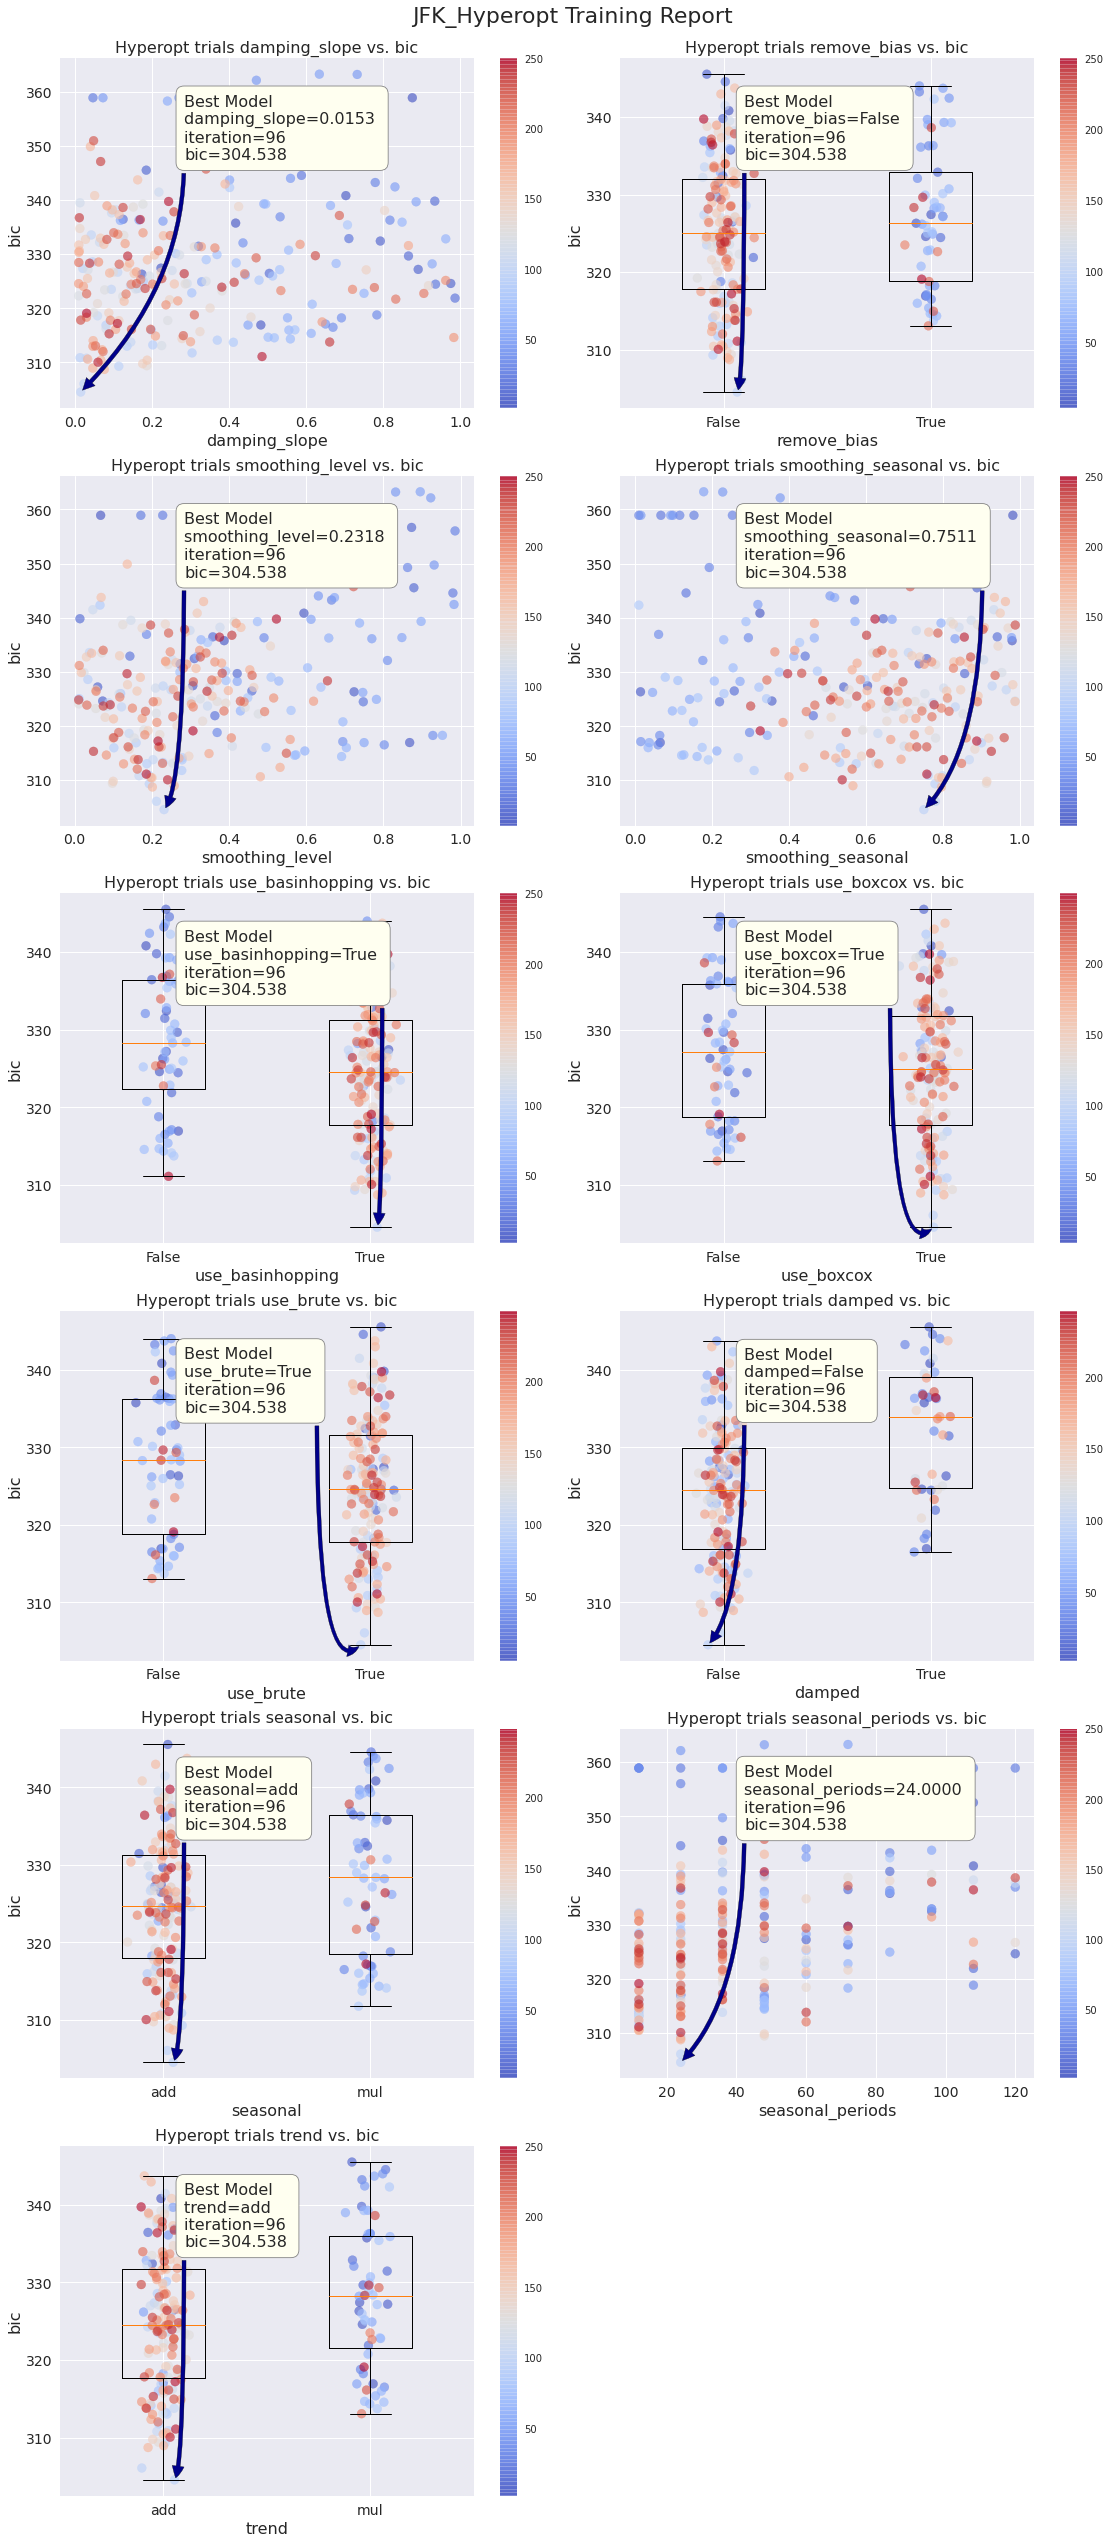

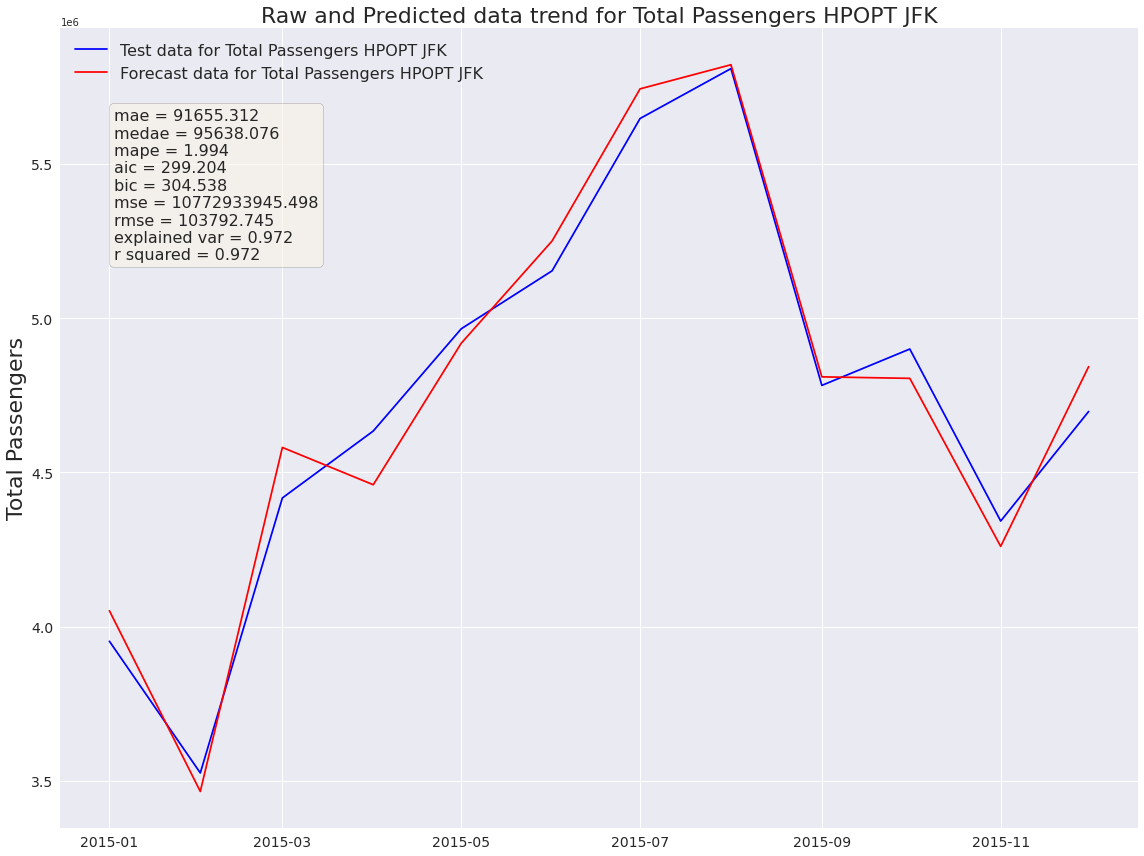

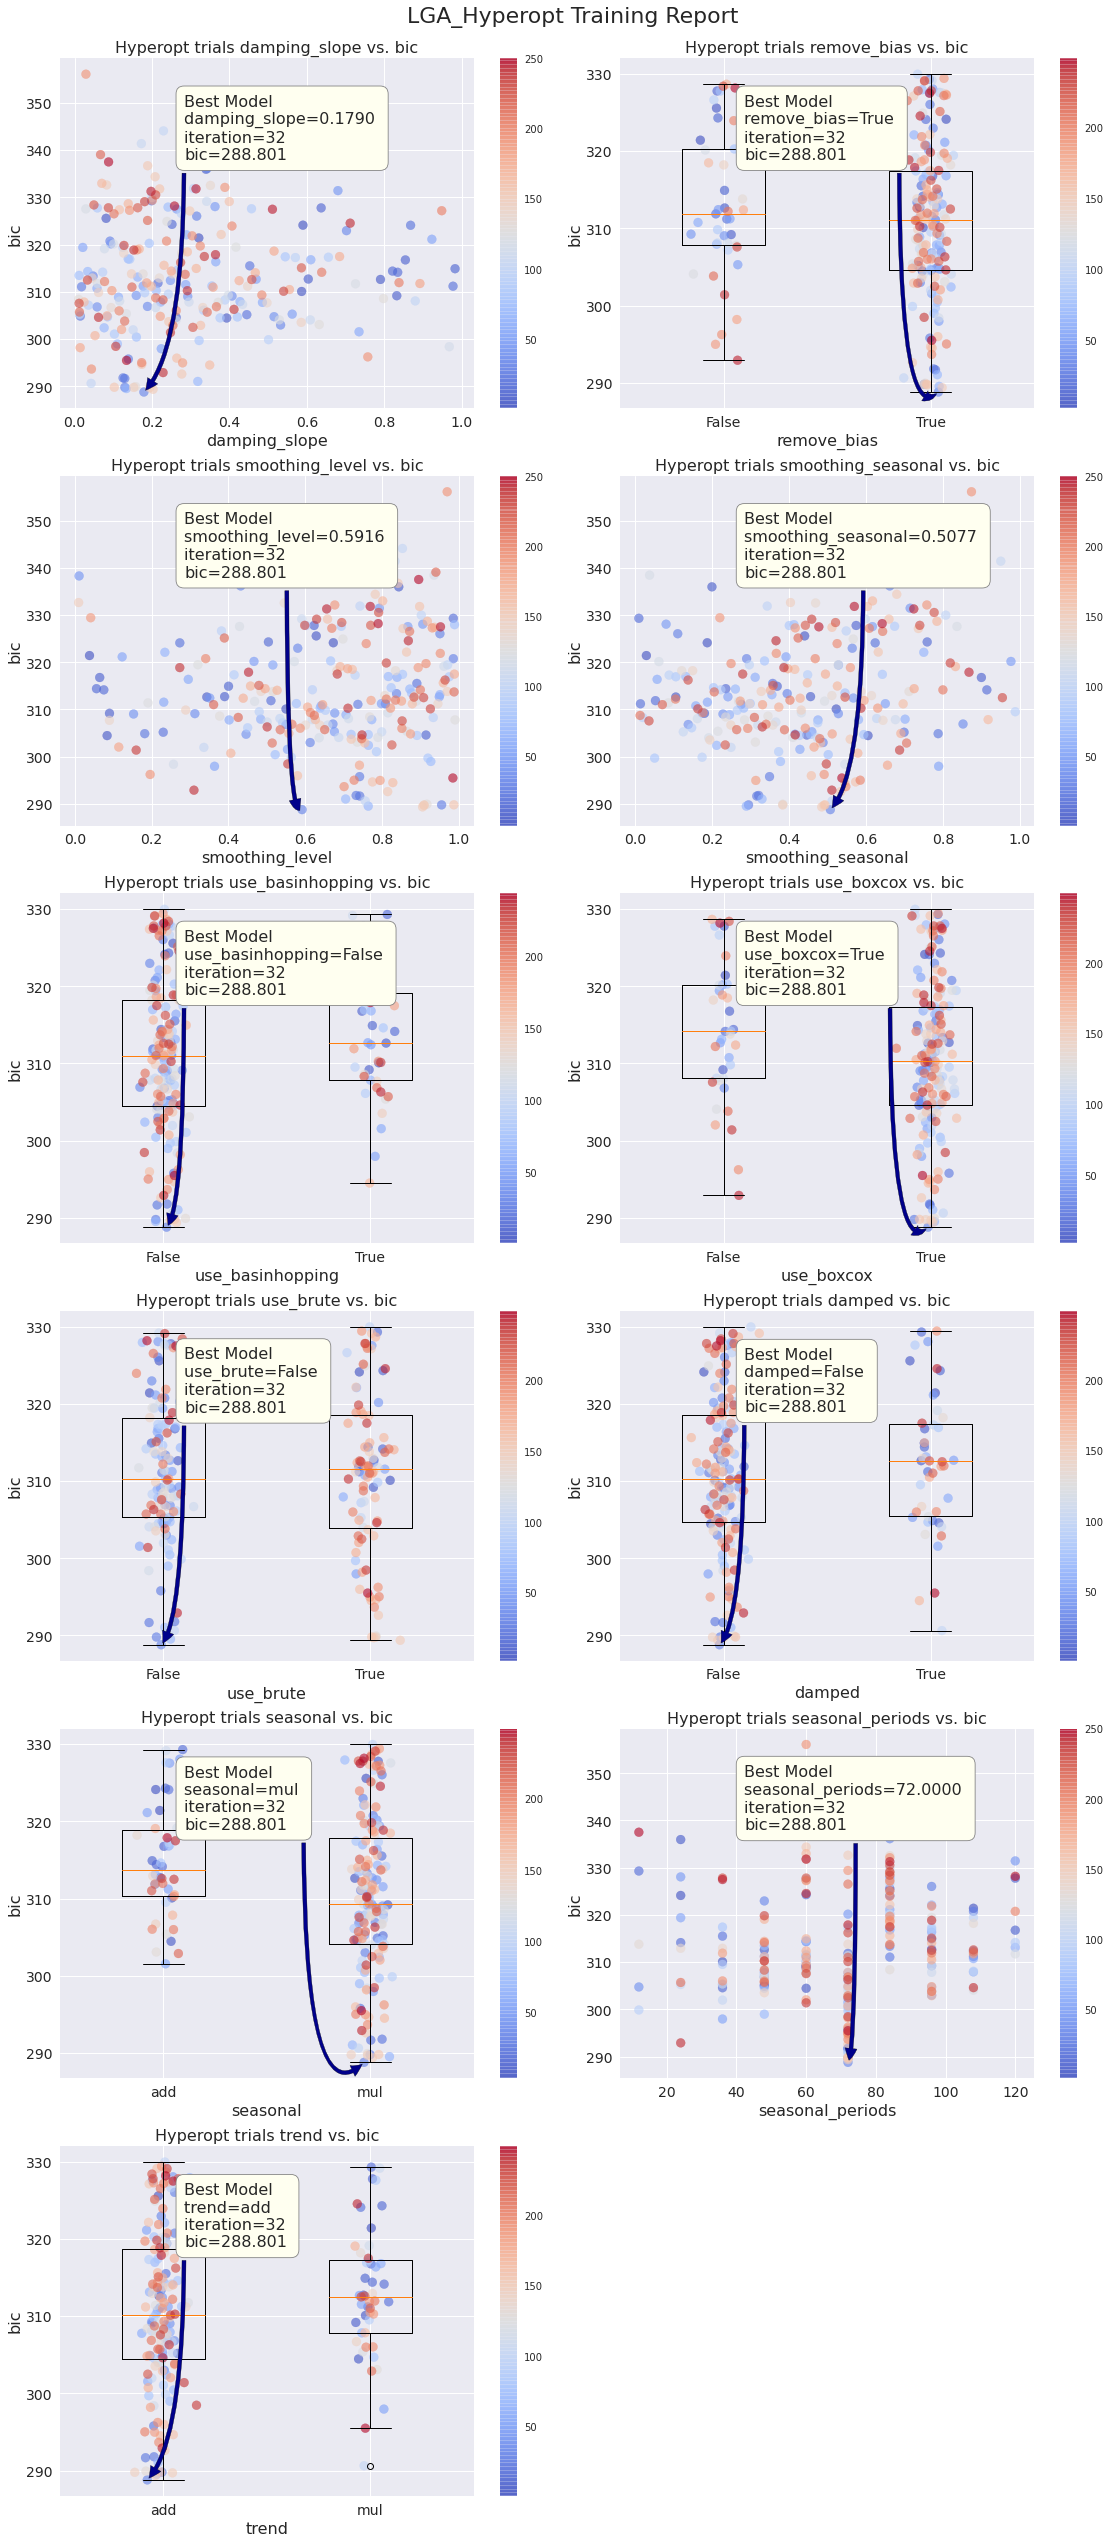

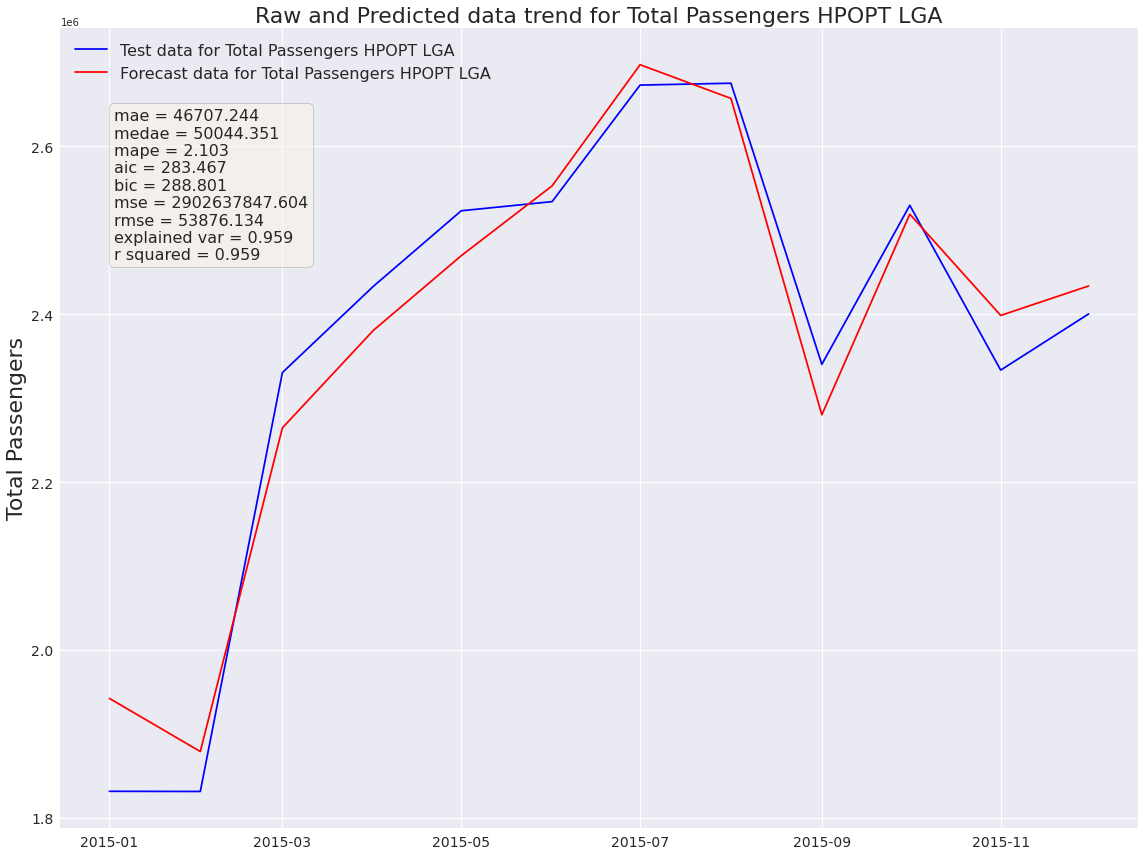

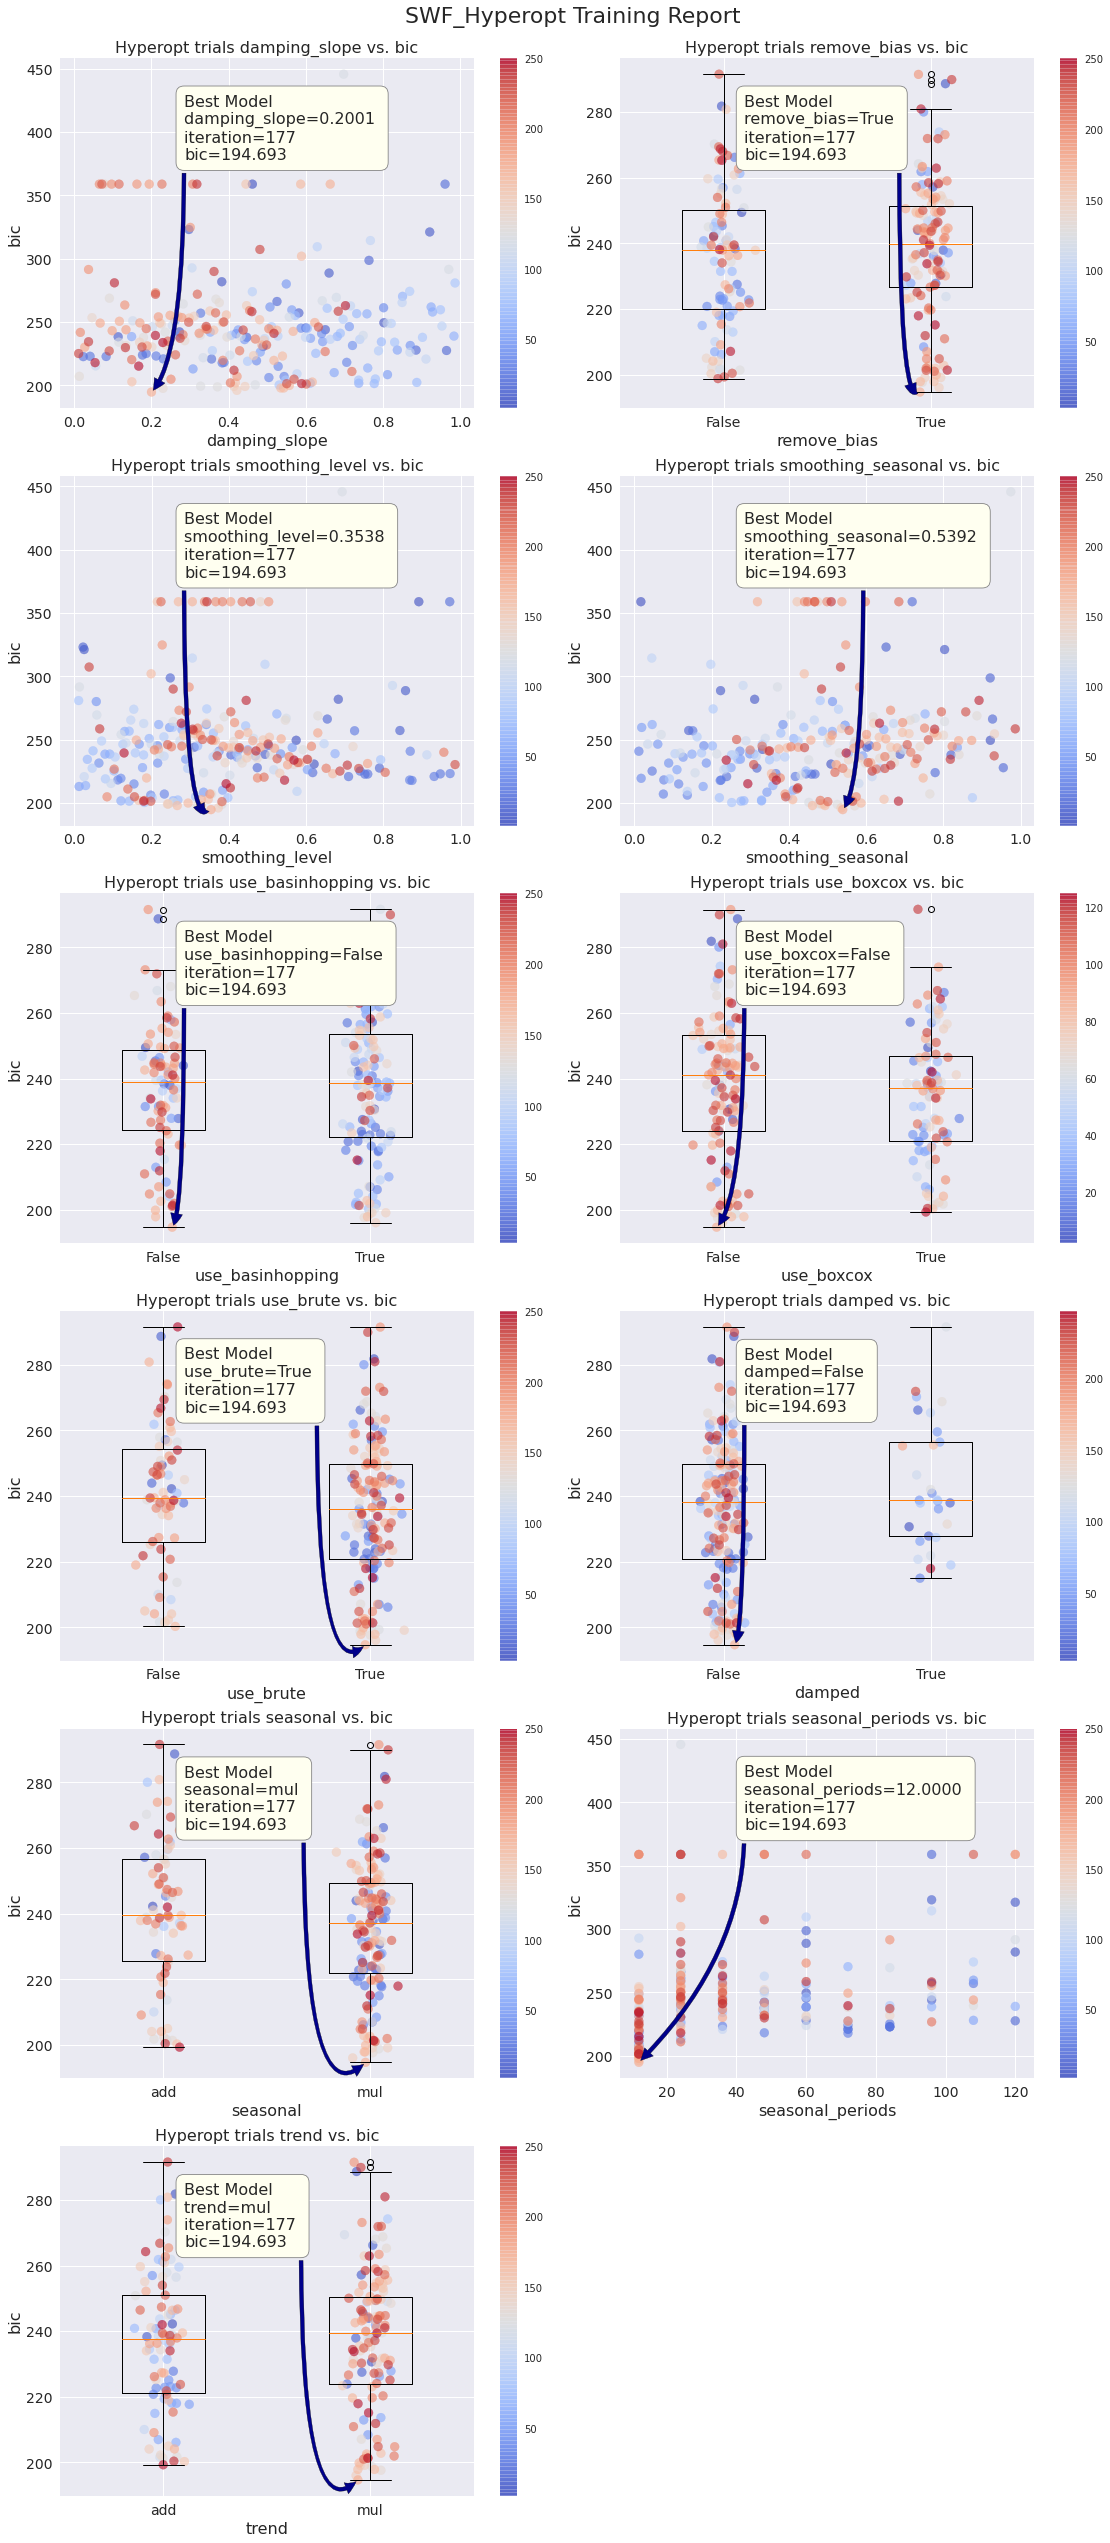

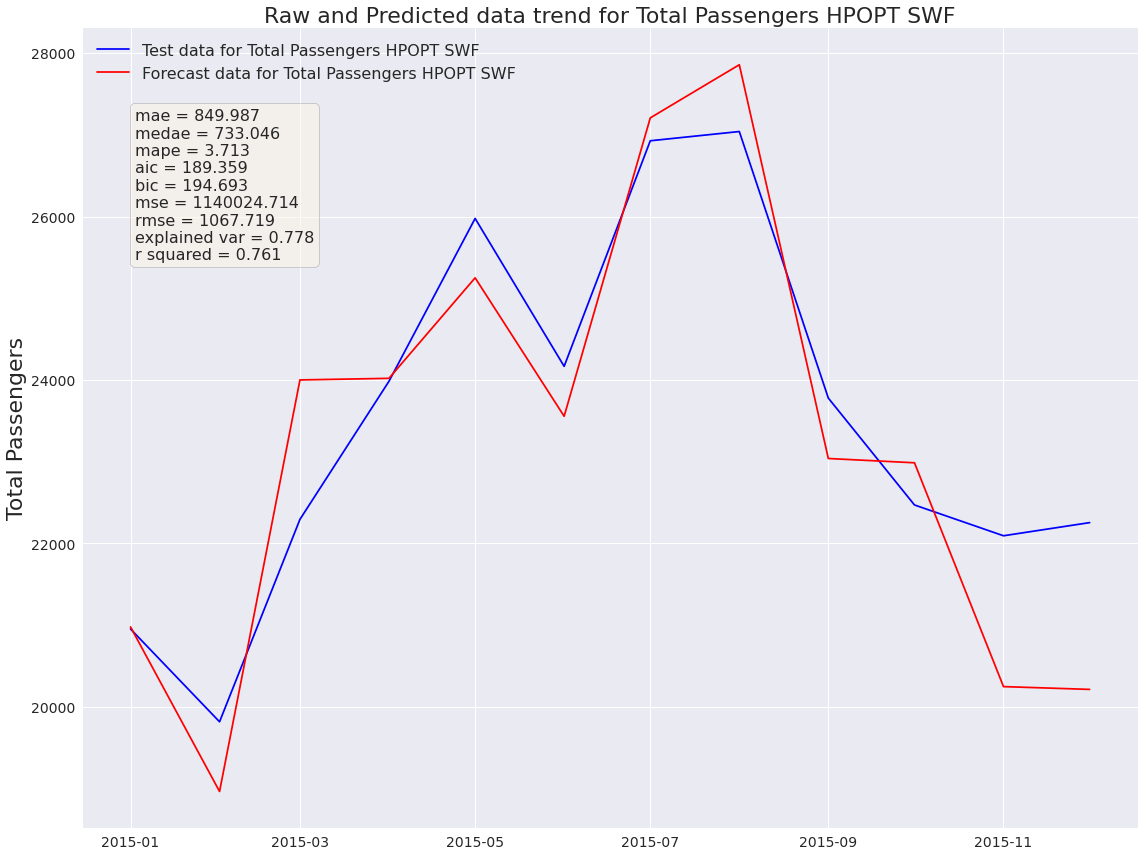

In [16]:
%time timed_tuning = run_all_models(**all_model_config2)

Ok, another favorite quote of mine by the eminent Lebanese-American satirist Gibran Khalil Gibran:<br>
> "I have seen the future and it is very much like the present, only longer."<br><br>
(when applying this quote to statistical forecasting, it's prescience is astounding... we are predicting the future merely based on what we've seen of the past - which should <b><u><i>always be a very serious and strongly understood cautionary tale applicable to all forms of applications of ML</i></u></b>. We <i><b>cannot see the future</b></i>, we are merely guessing at the future based on what has happened before.

## The elephant in the room...
After seeing the return result from our `run_all_models()` function, as well as the well-founded concern in the runtime of tuning a mere 4 airports, I'm hoping that you're thinking somewhere along the lines of...<br>
'Ok, so, what next?'
> There are more than a few concerns to be addressed for moving from the 'modeling solution' to 'useful service that others can use'. These concerns are:
1. Where do we put the return results? Do we save them to disk?
2. Where can we save the forecast data so that others can use it? A table in a Database? 
3. All of those metrics, visualizations, and artifacts... how do we store these for historical purposes?
4. What about our code? Shouldn't we be storing this somewhere other than as a Jupyter notebook on a VM running on our computer?<br>
<p> These are all very valid concerns, many of which we will be covering in the next section of Chapter 7's code examples as we move away from single-machine VM execution and into the world of distributed computing on Apache Spark.</p>